### **군집화 기반 앙상블 페어선택 알고리즘**
기여자 : 12기 최문석, 13기 최원준  

페어트레이딩을 위한 페어선택 알고리즘을 테스트합니다.

## 1. 동기

## 2. 관련 연구

## 3. 데이터셋
- 데이터셋은 FnGuide에서 제공하는 데이터를 사용하였습니다.


In [166]:
import os
import glob
import math
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

In [167]:
# matplotlib library load
import matplotlib.pyplot as plt

# plot 한글 보이게
from matplotlib import rc
rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

In [168]:
csv_data = pd.read_csv(r"../data/Train_Data.csv", encoding='CP949')
val_data = pd.read_csv(r"../data/Validation Data.csv", encoding='CP949')
test_data = pd.read_csv(r"../data/Test_Data.csv", encoding='CP949')

C:\Users\user\AppData\Local\Temp\ipykernel_40360\3724181354.py:1: DtypeWarning: Columns (3,4,9,12,18,20,26,27,28,30,32,36,37,44,48,50,54,56,61,63,65,66,68,71,72,73,75,77,80,82,89,91,92,94,96,108,109,112,113,115,116,119,124,130,131,132,133,136,142,143,146,152,153,154,155,158,161,162,163,166,168,169,173,174,175,180,183,185,186,187,192,194,198,199,202,203,204,207,209,210,212,215,216,217,218,220,222,230,231,232,236,245,248,250,251,252,258,259,260,261,262,263,267,269,271,276,279,282,285,286,287,288,290,293,294,295,297,299,300,302,303,312,314,317,318,319,322,323,325,327,328,340,351,353,357,365,374,379,391,393,395,397,399,400,402,405,406,408,410,413,415,416,419,422,423,427,438,439,445,446,448,450,451,454,464,465,467,468,473,475,477,486,493,495,496,498,499,504,506,508,510,511,517,519,521,526,543,546,558,560,561,562,565,571,572,574,576,579,580,586,591,596,599,600,601,605,616,622,623,625,627,635,639,641,643,648,652,659,663,667,671,678,679,680,684,687,689,690,695,698,700,703,704,711,716,719,721,7

In [169]:
csv_data.columns = csv_data.iloc[0]
csv_data = csv_data.iloc[1:]
csv_data.set_index('Symbol Name', inplace=True)
csv_data = csv_data.replace(',', '', regex=True).astype(float)

val_data.columns = val_data.iloc[0]
val_data = val_data.iloc[1:]
val_data.set_index('Symbol Name', inplace=True)
val_data = val_data.replace(',', '', regex=True).astype(float)

test_data.columns = test_data.iloc[0]
test_data = test_data.iloc[1:]
test_data.set_index('Symbol Name', inplace=True)
test_data = test_data.replace(',', '', regex=True).astype(float)

In [170]:
print('행 :', len(csv_data), '열 :', len(csv_data.T))
print('행 :', len(val_data), '열 :', len(val_data.T))
print('행 :', len(test_data), '열 :', len(test_data.T))

행 : 2979 열 : 1210
행 : 732 열 : 1210
행 : 1235 열 : 1210


In [171]:
total_data = pd.concat([csv_data, val_data, test_data])
total_data = total_data.dropna(axis=1)

In [172]:
len(total_data)

4946

In [173]:
csv_data = total_data.iloc[:2979]
val_data = total_data.iloc[2979:2979+732]
test_data = total_data.iloc[2979+732:]
simul_data = val_data = total_data.iloc[:2979+732]

In [174]:
print('행 :', len(csv_data), '열 :', len(csv_data.T))
print('행 :', len(val_data), '열 :', len(val_data.T))
print('행 :', len(test_data), '열 :', len(test_data.T))

행 : 2979 열 : 523
행 : 3711 열 : 523
행 : 1235 열 : 523


In [175]:
data = csv_data
data = np.log(data / data.shift(1))
data = data.dropna(axis=0)
log_return_data = data
scaler = StandardScaler()
datanp = scaler.fit_transform(data)
data = pd.DataFrame(datanp, index=data.index, columns=data.columns)

In [176]:
data

0                삼성전자    SK하이닉스       현대차        기아  POSCO홀딩스     NAVER   
Symbol Name                                                               
2004-04-02  -0.926434  0.249333 -0.097784 -0.508609  1.318608  1.320511  \
2004-04-06   2.675056  2.938137  1.123007  0.795804 -0.005032  0.869067   
2004-04-07   0.420620 -0.008841  1.249587  1.093233  0.999743  0.609867   
2004-04-08   0.417009 -0.600996  0.449454  0.138019  1.943378 -0.474571   
2004-04-09  -0.880830  0.229327 -1.029217 -1.609273  0.402363  0.606396   
...               ...       ...       ...       ...       ...       ...   
2016-03-25   0.228330 -0.339269 -0.708678 -0.212902  0.109349 -0.684303   
2016-03-28   0.227202 -0.680024  0.263187 -0.331807  0.222914  0.205830   
2016-03-29  -0.175343  0.384377  0.261383  0.838276  1.007502  1.308987   
2016-03-30   0.705952 -0.289221  0.122296 -0.600030  0.986528 -0.204747   
2016-03-31   0.144331 -0.577016 -0.848681 -0.768047 -0.005032 -0.032504   

0               삼성SDI      LG화학      신한지주     현대모비스  ...        신풍      동원수산   
Symbol Name                                          ...                       
2004-04-02   0.007243 -0.228593  2.210629  0.453503  ... -0.161318 -0.769039  \
2004-04-06   0.958787  0.677269  1.908726 -0.101080  ... -0.480541 -1.443244   
2004-04-07  -0.465739 -0.364569 -0.010723 -0.819319  ... -0.003751  3.368863   
2004-04-08   0.362495 -0.578937 -0.010723  0.218523  ... -0.405851  3.041222   
2004-04-09  -1.310849 -0.515761 -0.507955 -1.404027  ... -0.165829 -3.004876   
...               ...       ...       ...       ...  ...       ...       ...   
2016-03-25  -0.593623  0.523930 -0.282231 -0.195938  ...  0.442893 -0.103453   
2016-03-28  -0.195040 -0.439724 -0.229115 -0.196636  ... -0.170607 -1.313983   
2016-03-29   0.209526  0.462534  0.153170  0.239284  ... -1.021101  0.277021   
2016-03-30  -0.439120  0.867616 -0.836227 -0.022163  ...  0.224771  0.872532   
2016-03-31  -0.156297 -0.429489 -0.010723 -0.196287  ... -0.693618 -0.353155   

0             제이준코스메틱      금호전기      한국주강     한솔PNS        한창       SHD   
Symbol Name                                                               
2004-04-02  -0.163159  0.593812 -1.400357  0.403015 -1.159697  0.874883  \
2004-04-06   0.319784  1.209170  1.053722  0.576910  3.222090 -0.516444   
2004-04-07  -0.065679  1.169684  2.064145  0.754934  2.956851 -0.336839   
2004-04-08   0.364169  1.496573  1.697832 -0.561806 -2.896872  0.746809   
2004-04-09  -0.064467  1.781344  0.714896 -0.774096 -1.522637 -0.581818   
...               ...       ...       ...       ...       ...       ...   
2016-03-25   0.002191  1.040212  0.087191  1.057919  0.948822  0.310727   
2016-03-28  -0.054311 -1.271200 -0.016466  0.776451  0.070961 -0.420482   
2016-03-29   0.143065 -0.646742  0.648660 -0.257534  0.019525 -0.178710   
2016-03-30   0.142392 -0.120147  0.034088  0.672443 -0.006932  0.798473   
2016-03-31  -0.053679  0.014784  0.184896 -0.508192 -0.084737 -0.337052   

0               비케이탑스      일정실업  
Symbol Name                      
2004-04-02   0.367881 -0.011925  
2004-04-06   0.181002  0.314694  
2004-04-07   0.179646  0.150531  
2004-04-08   0.824720  0.311299  
2004-04-09  -0.527618  0.947247  
...               ...       ...  
2016-03-25  -0.400700 -0.394372  
2016-03-28  -0.081894  0.141430  
2016-03-29  -0.739052  0.522187  
2016-03-30   0.330325 -0.011925  
2016-03-31  -0.331873 -0.546038  

[2978 rows x 523 columns]

In [177]:
from scipy.linalg import svd
U, s, VT = svd(data)

In [178]:
s

array([519.04952955, 156.53264329, 134.43358865, 114.00769563,
       108.98174637, 102.93377572,  99.10243528,  92.78042733,
        90.12765422,  86.3925155 ,  84.00457825,  82.24843001,
        81.31657771,  80.0855921 ,  79.01670121,  77.55114808,
        77.24855993,  75.9861984 ,  75.69227921,  74.6644143 ,
        74.07280994,  73.00039914,  72.91626979,  72.47026049,
        71.96429053,  71.3997734 ,  71.27092544,  70.58782293,
        70.49099087,  70.3399412 ,  69.70853507,  69.48003959,
        69.05283115,  68.88765895,  68.78281371,  68.43181072,
        67.97542575,  67.83464611,  67.64323822,  67.53273875,
        67.4798954 ,  67.24640761,  67.0071832 ,  66.75930033,
        66.70801203,  66.45037599,  66.19795569,  66.10854281,
        65.8147007 ,  65.62540064,  65.40735353,  65.2592725 ,
        65.20610292,  64.94411798,  64.8128285 ,  64.59209653,
        64.53094983,  64.39033139,  64.15727996,  64.05859878,
        63.86215477,  63.78431617,  63.49600057,  63.44

In [179]:
V = VT.T
PC_V = V[:,0:15]
print(PC_V.shape)

(523, 15)


In [180]:
pc_names = ['PC' + str(i) for i in range(1, 15 + 1)]

eigendata = pd.DataFrame(PC_V, index=data.columns, columns=pc_names)

In [181]:
eigendata

PC1       PC2       PC3       PC4       PC5       PC6   
0                                                                      
삼성전자      0.051608 -0.086900  0.024547 -0.106263  0.097225 -0.079084  \
SK하이닉스    0.053757 -0.036038 -0.027532 -0.044215  0.098690 -0.033673   
현대차       0.048063 -0.108819 -0.030098 -0.151539  0.139224 -0.017024   
기아        0.049157 -0.086164 -0.024896 -0.131306  0.123545 -0.022369   
POSCO홀딩스  0.057713 -0.114529  0.027419 -0.040234 -0.052006  0.041171   
...            ...       ...       ...       ...       ...       ...   
한솔PNS     0.036660  0.035022 -0.006996 -0.009138 -0.005059 -0.017083   
한창        0.023991  0.028657 -0.021920  0.015112  0.016547 -0.044940   
SHD       0.034601  0.046037 -0.004274 -0.022439 -0.029465 -0.020115   
비케이탑스     0.040430  0.033217 -0.024920  0.011900  0.003248 -0.044076   
일정실업      0.031503  0.023387  0.002171 -0.043928 -0.043305 -0.026123   

               PC7       PC8       PC9      PC10      PC11      PC12   
0                                                                      
삼성전자      0.030442 -0.039721  0.040306 -0.130233  0.027775 -0.054342  \
SK하이닉스    0.012960 -0.004901 -0.028432 -0.064145  0.035776 -0.047852   
현대차       0.057756  0.092637 -0.009005 -0.148340  0.084657  0.000327   
기아        0.063613  0.108985 -0.024950 -0.133547  0.076462  0.001771   
POSCO홀딩스  0.004204 -0.053862  0.044927 -0.161254  0.015399  0.007065   
...            ...       ...       ...       ...       ...       ...   
한솔PNS    -0.002823 -0.032019 -0.017032  0.018301 -0.009538 -0.038215   
한창        0.001664 -0.088655  0.038293 -0.035750  0.014185 -0.009476   
SHD      -0.008490  0.001031  0.024582 -0.022930 -0.029400  0.023452   
비케이탑스    -0.007971 -0.047506 -0.025700 -0.005247 -0.008700 -0.057339   
일정실업     -0.025872  0.017466  0.074761  0.008812  0.045634 -0.030525   

              PC13      PC14      PC15  
0                                       
삼성전자      0.128491 -0.053499  0.065846  
SK하이닉스    0.091883 -0.036453  0.070797  
현대차      -0.025269  0.069170  0.024045  
기아       -0.018294  0.070218 -0.000688  
POSCO홀딩스  0.112512 -0.057611  0.011707  
...            ...       ...       ...  
한솔PNS    -0.019090 -0.040053 -0.022990  
한창        0.023888  0.004416  0.017062  
SHD       0.041311  0.037503 -0.020212  
비케이탑스    -0.018640  0.034960 -0.030484  
일정실업      0.017402  0.008409 -0.055221  

[523 rows x 15 columns]

In [182]:
pca_df = eigendata

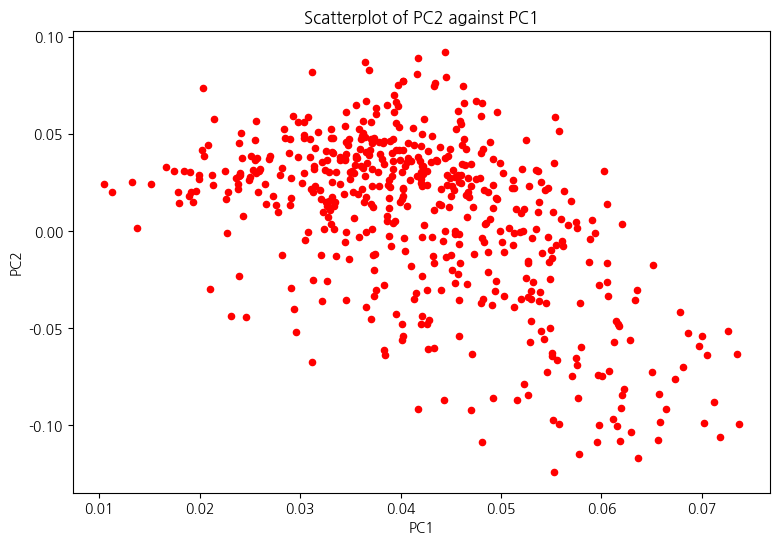

In [183]:
'''
Visualising the PCA in dimension R^2 (PC1 and PC2)
'''

fig, ax = plt.subplots(figsize=(9,6))
pca_df.plot(x="PC1", y="PC2", kind="scatter", marker="o",
    title="Scatterplot of PC2 against PC1", ax=ax, color="r")
plt.show()

---

**20개 주성분 선택**  
카이저-가트맨 규칙(Kaiser-Guttman Criterion)의 고윳값1기준

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\

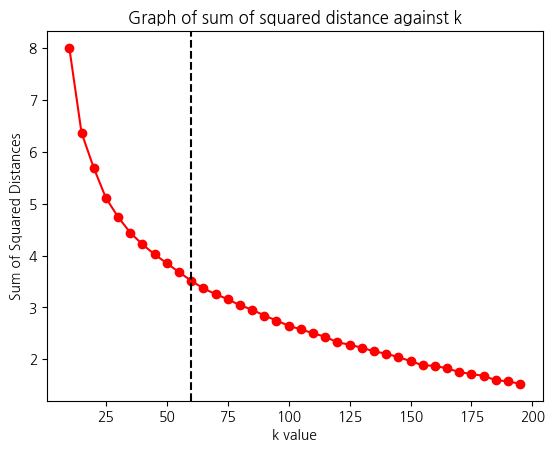

From the graph above, we can see that the optimal k-value is at the elbow, at k = 60


In [184]:
'''Make a pointer to store clustering results'''

cluster_results = {}

'''K-Means Clustering'''

def optimise_k(pca_df):

    error = []
    ks = []
    
    for i in range(10, 200, 5): # For loop from 10 to 200 with intervals of 5 and calculate the respective sum of squared distances for i number of centroids

        # Initialise the KMeans function with the i number of centroids.
        # By default, KMeans function uses the KMeans++ Method of initialisation the centroids.
        kmeans = KMeans(n_clusters=i) 
        
        # Fits the model with pcd_df and applies KMeans algorithm on pca_df.
        kmeans.fit(pca_df)
        
        # Using the attribute ".inertia_" returns the sum of squared distances of datapoints to their closest cluster center.
        # It is appended into error to be plotted as the y-axis.
        error.append(kmeans.inertia_)
        
        # The number of centroids, i, is appended to ks to be plotted as the x-axis.
        ks.append(i)
    
    # Plot graph of "Sum of Squared Distances" against "k value".
    # Using this graph, the optimal number of centroids can be found via the elbow method
    plt.plot(ks, error, marker="o", color="r")
    plt.title("Graph of sum of squared distance against k")
    plt.xlabel("k value")
    plt.ylabel("Sum of Squared Distances")
    plt.axvline(60, color='black', linestyle='--')
    plt.show()

def cluster_kmeans(pca_df, k):

    # Initialise the KMeans function with the k number of centroids.
    kmeans = KMeans(n_clusters=k)

    # Fits the model with pcd_df and applies KMeans algorithm on pca_df.
    kmeans.fit(pca_df)

    # Using the method .predict(X), it calculates the closest cluster each datapoint in dataset X belongs to.
    results = kmeans.predict(pca_df)

    # Plot the cluster results.
    fig, ax = plt.subplots(figsize=(9,6))
    pca_df.plot(x="PC1", y="PC2", kind="scatter", 
        title=f"K-Means Cluster Results, k={k}", c=results, cmap="jet", ax=ax)
    plt.show()
    return results

optimise_k(pca_df)
print(f"From the graph above, we can see that the optimal k-value is at the elbow, at k = 60")

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


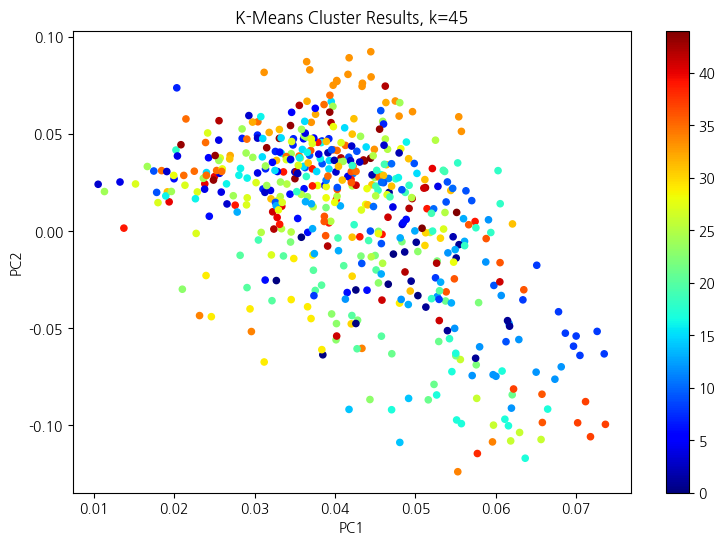

Therefore, we plot the K-Means results for the optimal k-value, 45


In [185]:
'''Plotting the K-Means Cluster Results'''

# K-Means Clustering is applied on pca_df for k = 45
kmeans_results = cluster_kmeans(pca_df,k=45)

# K-Means Clustering results are saved in cluster_results
cluster_results[f"KMeans"] = kmeans_results

print(f"Therefore, we plot the K-Means results for the optimal k-value, 45")

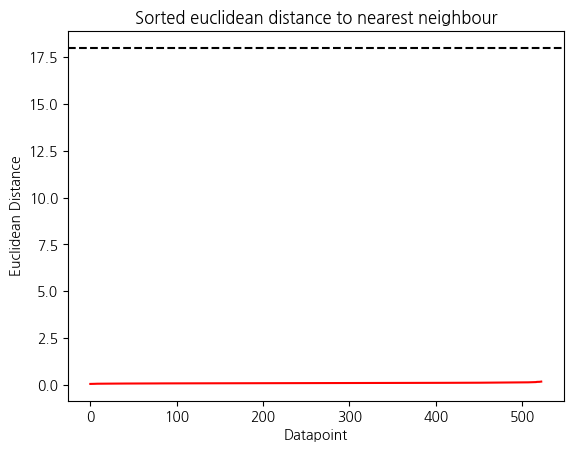

From the graph above, we can see that the optimal epsilon is at the elbow, at epsilon = 18


In [186]:
'''
DBSCAN Clustering:
'''

def optimise_epsilon(pca_df):

    # Initialise the NearestNeighbors function with 2 neighbors 
    # This is to find optimal value of epsilon based on an optimisation algorithm
    neigh = NearestNeighbors(n_neighbors=2)

    # Fits the model with pcd_df
    nbrs = neigh.fit(pca_df)

    # Using the method .kneighbors(X), the k-Neighbours for datatpoints in datatset X are found
    # By default, this method returns the distances array which is found in the 0 index
    distances = nbrs.kneighbors(pca_df)[0]

    # Sort distances row-wise
    distances = np.sort(distances,axis=0) 

    # Remove the 0-index value (Euclidean distance to itself which is 0)
    distances = distances[:,1:]

    # Plot graph of "Euclidean Distance" against "Datapoint".
    # Using this graph, the optimal epsilon value can be found via the elbow method
    plt.plot(distances, color="r")
    plt.title("Sorted euclidean distance to nearest neighbour")
    plt.xlabel("Datapoint")
    plt.ylabel("Euclidean Distance")
    plt.axhline(y=18, color='black', linestyle='--')
    plt.show()    

def cluster_dbscan(pca_df, eps, min_samples):

    # Initialise the DBSCAN function with eps and min_samples.
    # eps is a float value and is the maximum distance between two samples for one to be considered as in the neighborhood of the other
    # min_samples is the number of samples (or total weight) in a neighborhood for a point to be considered as a core point. 
    # This includes the point itself.
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # Using the method .fit_predict(X), clusters from a data or distance matrix and predict labels are computed
    results = dbscan.fit_predict(pca_df)
    
    # Plot the cluster results.
    fig, ax = plt.subplots(figsize=(9,6))
    pca_df.plot(x="PC1", y="PC2", kind="scatter", 
        title=f"DBSCAN Cluster Results", c=results, cmap="jet", ax=ax)
    plt.show()

    # Get number of clusters formed.
    num_clusters = np.max(results)
    print(f"For the epsilon value of {eps}, the number of clusters is {num_clusters}")

    return results

optimise_epsilon(pca_df) 
print(f"From the graph above, we can see that the optimal epsilon is at the elbow, at epsilon = 18")

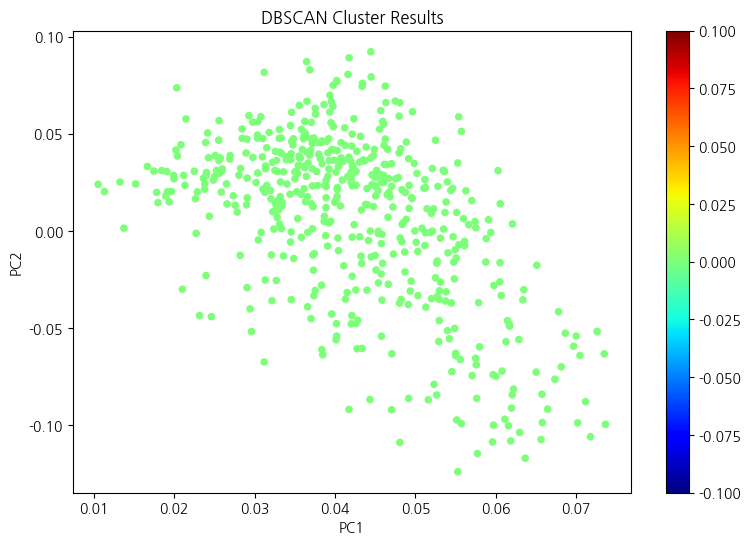

For the epsilon value of 18, the number of clusters is 0


In [187]:
'''Plotting the DBSCAN Cluster Results'''

# DBSCAN Clustering is applied on pca_df for eps = 20 and min_samples = 2
results = cluster_dbscan(pca_df, eps=18, min_samples=2)

# DBSCANS Clustering results are saved in cluster_results, a dict
cluster_results["DBSCAN"] = results

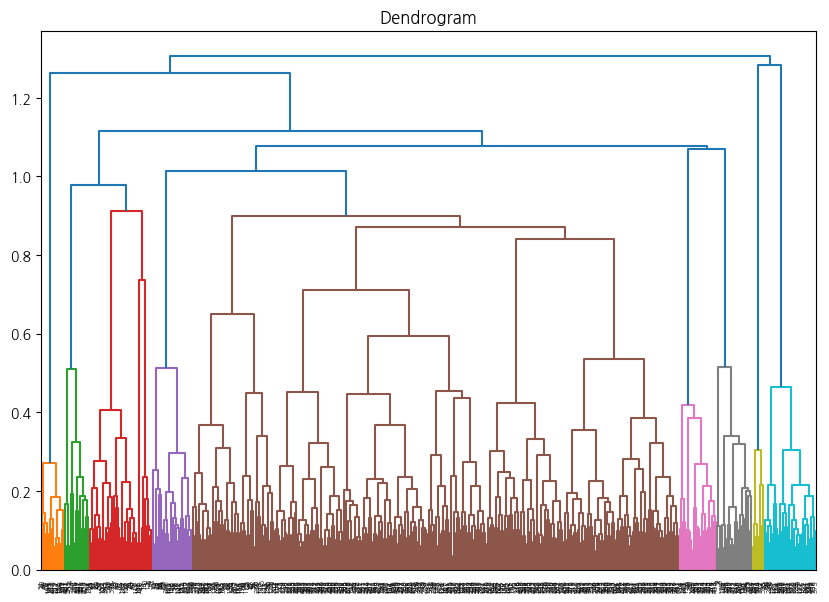

In [188]:
'''
Hierarchical Clustering (AgglomerativeClustering)
'''

def cluster_hierar(pca_df, n):

    # Initialise the AgglomerativeClustering function with n clusters.
    # Fits the model with pca_df and applies Agglomerative Clustering algorithm on pca_df.
    hierar = AgglomerativeClustering(n_clusters=n, ).fit(pca_df)

    # Using the method .fit_predict(X), it fits and return the result of each datapoint's clustering assignment.
    results = hierar.fit_predict(pca_df)

    # Plot cluster results.
    fig, ax = plt.subplots(figsize=(9,6))
    pca_df.plot(x="PC1", y="PC2", kind="scatter", 
        title=f"Agglomerative Clustering Results, n={n}", c=results, cmap="jet", ax=ax)
    plt.show()

    return results

def draw_dendrogram(pca_df):
    
    # Initialise Linkage function with linkage method = "ward".
    # linkage returns a linkage matrix, which is needed for the dendrogram to be plotted.
    linked = linkage(pca_df,method = "ward") 

    # Plot dendrogram results.
    plt.figure(figsize =(10,7))
    plt.title("Dendrogram")
    dendrogram(linked,
                orientation = "top",
                distance_sort = "descreasing",
                show_leaf_counts = True)
    plt.show()

draw_dendrogram(pca_df)

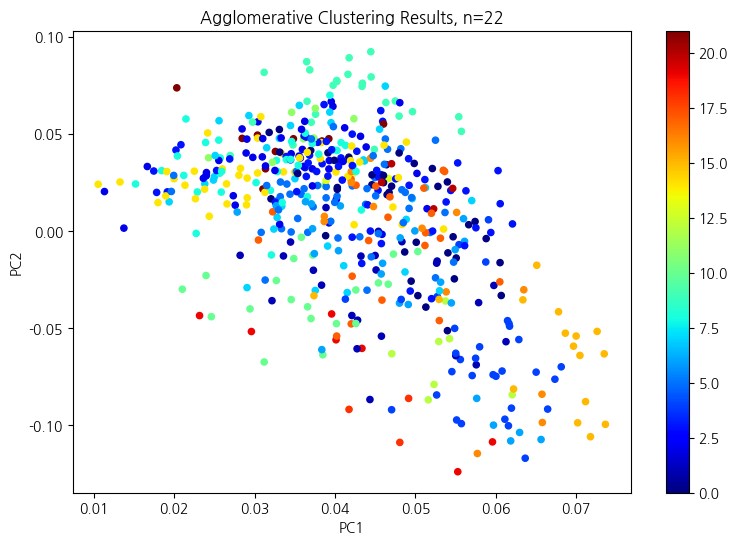

In the case of Hierarchical Clustering, we chose the optimal number of clusters to be sqrt(N)=22, where N is the number of datapoints


In [189]:
'''Plotting the Hierarchical Cluster Results'''
# Hierarchical Clustering is applied on pca_df for n_clusters = sqrt(N)
results = cluster_hierar(pca_df, int(pca_df.shape[0]**0.5)) 

# Hierarchical Clustering results are saved in cluster_results
cluster_results["Hierarchical"] = results

print(f"In the case of Hierarchical Clustering, we chose the optimal number of clusters to be sqrt(N)=22, where N is the number of datapoints")

In [190]:
'''
Cluster Results -> Groupings of stocks/ETFs:
1. First, we need to map the cluster ids to the symbols of our stocks to get groups of stocks
2. Then store the clusters into a pointer -> "groups"
'''
norm_symbols = pca_df.index

# Return array of the symbols of stocks.
print(norm_symbols.shape) 

# Contains cluster group assignments for each algorithm.
print([x.shape for x in cluster_results.values()])

def map_clusters(cluster_result):
    grouping = [[] for _ in range(max(cluster_result)+1)]
    for i, res in enumerate(cluster_result):
        grouping[res].append(norm_symbols[i])
    
    grouping = [g for g in grouping if 1<len(g)<=10] # Keep clusters with <=10 members.
    
    return grouping

groups = {}
for algorithm, cluster_result in cluster_results.items():
    groups[algorithm] = map_clusters(cluster_result)


print("Number of valid clusters:", {k:len(v) for k,v in groups.items()})
print("Example cluster:", groups["Hierarchical"][0])

(523,)
[(523,), (523,), (523,)]
Number of valid clusters: {'KMeans': 18, 'DBSCAN': 0, 'Hierarchical': 7}
Example cluster: ['동원산업', '사조대림', '사조산업', '신라교역', 'CJ씨푸드', '사조오양', '한성기업', '동원수산']


In [191]:
for i in range(0,len(groups["KMeans"])):
    print("Example cluster:", groups["KMeans"][i])

Example cluster: ['영풍', '태광산업', '아세아', 'KISCO홀딩스', 'CR홀딩스', '대한제분', 'KPX케미칼', '경방']
Example cluster: ['남해화학', '광명전기', '일신석재', '케이비아이동국실업', '조비', '선도전기']
Example cluster: ['동원산업', '사조대림', '사조산업', '신라교역', '사조오양', '한성기업', '동원수산']
Example cluster: ['NI스틸', '동양철관', '부국철강', 'DSR제강', '문배철강']
Example cluster: ['삼화콘덴서', '삼화전기', '삼화전자']
Example cluster: ['현대차', '기아', '현대모비스']
Example cluster: ['대원강업', '모토닉', '우신시스템', '한국무브넥스', '인지컨트롤스', '화승코퍼레이션', '인팩', '화천기계', '유성기업', '화천기공']
Example cluster: ['삼성전자', 'SK하이닉스', '삼성SDI', 'LG전자', 'LG', '삼성전기']
Example cluster: ['삼성화재', 'KT&G', '강원랜드', '한국가스공사', '율촌화학', '신도리코', '하이트진로홀딩스']
Example cluster: ['삼성E&A', '현대건설', '대우건설', 'GS건설', 'DL', 'HDC']
Example cluster: ['한온시스템', '에스엘', '화신', '서연', '에스제이지세종']
Example cluster: ['영진약품', '진원생명과학', '에이프로젠바이오로직스', '팜젠사이언스', '오리엔트바이오', '체시스']
Example cluster: ['신한지주', '한국전력', '기업은행', 'SK텔레콤', 'KT']
Example cluster: ['미래에셋증권', 'NH투자증권', '한국금융지주', '삼성증권', '대신증권']
Example cluster: ['동서', '한샘', '풀무원', '노루홀딩스', '벽산', '이건산업']


In [192]:
for i in range(0,len(groups["Hierarchical"])):
    print("Example cluster:", groups["Hierarchical"][i])

Example cluster: ['동원산업', '사조대림', '사조산업', '신라교역', 'CJ씨푸드', '사조오양', '한성기업', '동원수산']
Example cluster: ['삼성전자', 'SK하이닉스', '삼성SDI', 'LG전자', 'LG', '한화에어로스페이스', '삼성전기']
Example cluster: ['삼화콘덴서', '삼화전기', '삼화전자']
Example cluster: ['현대차', '기아', '현대모비스']
Example cluster: ['신한지주', '한국전력', '기업은행', 'SK텔레콤', 'KT', '강원랜드', '한국가스공사']
Example cluster: ['NI스틸', '동양철관', 'DSR제강', '문배철강']
Example cluster: ['유한양행', '한미사이언스', '녹십자', '대웅제약', '대웅', '녹십자홀딩스', '동아쏘시오홀딩스', '종근당홀딩스', '한독', '제일파마홀딩스']


In [193]:
for i in range(0,len(groups["DBSCAN"])):
    print("Example cluster:", groups["DBSCAN"][i])

In [194]:
cumulative_log_returns = log_return_data.cumsum()
cumulative_returns = np.exp(cumulative_log_returns) - 1

In [195]:
def clusterCumsumPlot(name_clustering_algorithm):
    for i in range(0, len(groups[name_clustering_algorithm])):
        plt.figure(figsize=(10, 6))
        cluster = groups[name_clustering_algorithm][i]
        for stock in cluster:
            if stock in cumulative_returns.columns:
                cumulative_returns[stock].plot(label=stock)
        plt.title(f'{name_clustering_algorithm} 군집화 알고리즘 - {i+1}번째 군집')
        plt.xlabel('날짜')
        plt.ylabel('누적수익률')
        plt.legend()
        plt.grid(True)
        plt.show()

In [196]:
clusterCumsumPlot("DBSCAN")

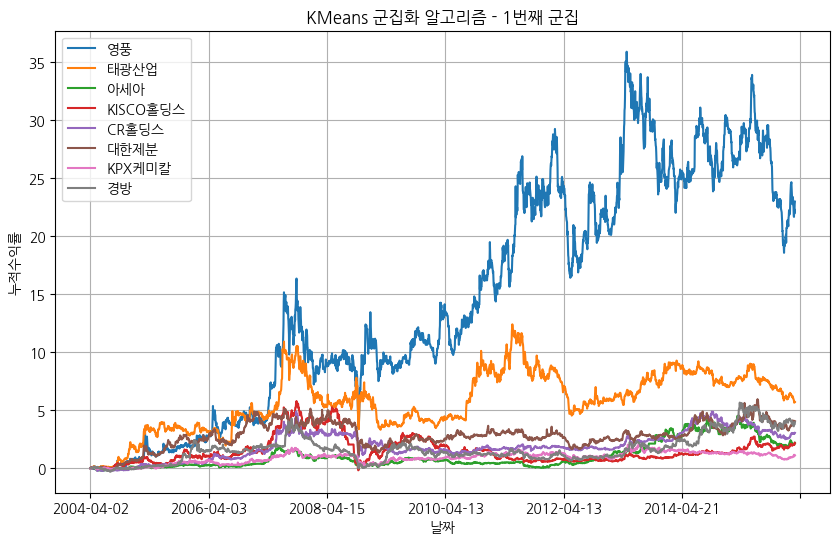

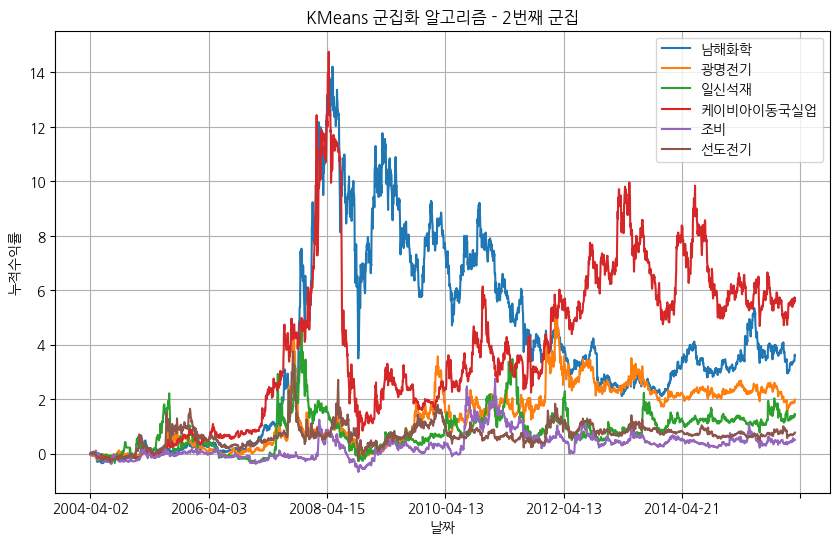

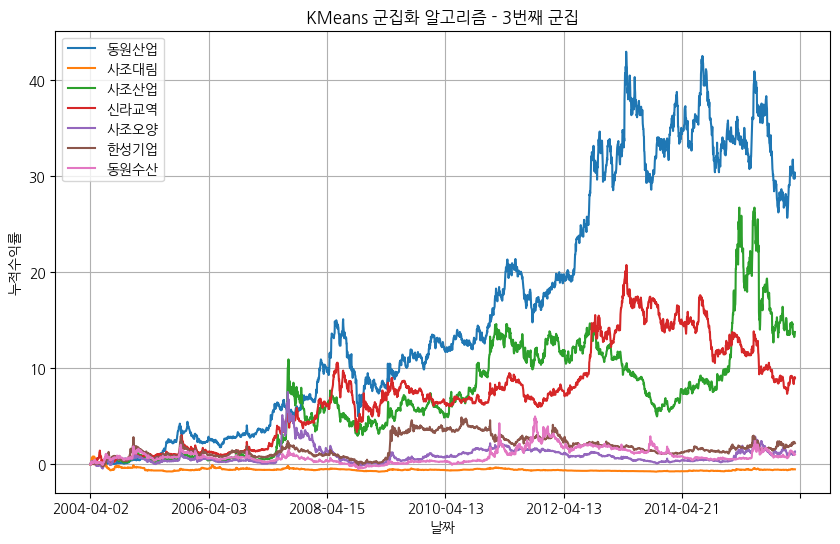

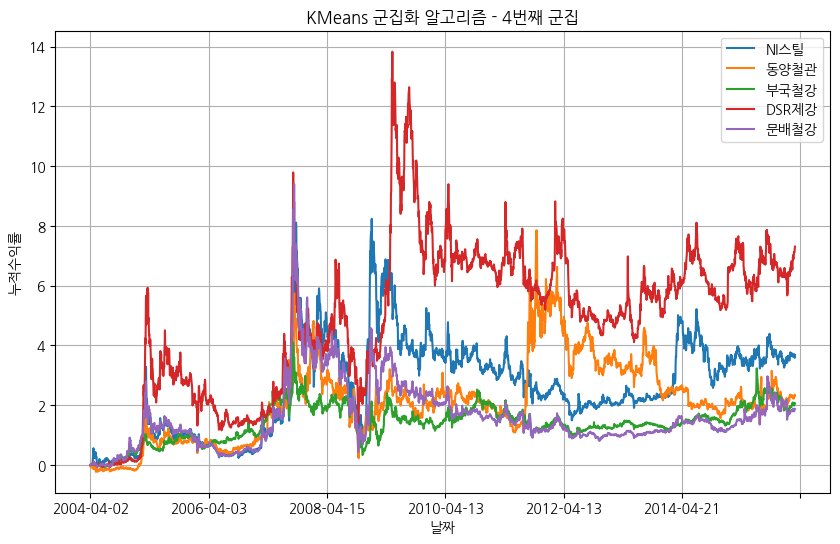

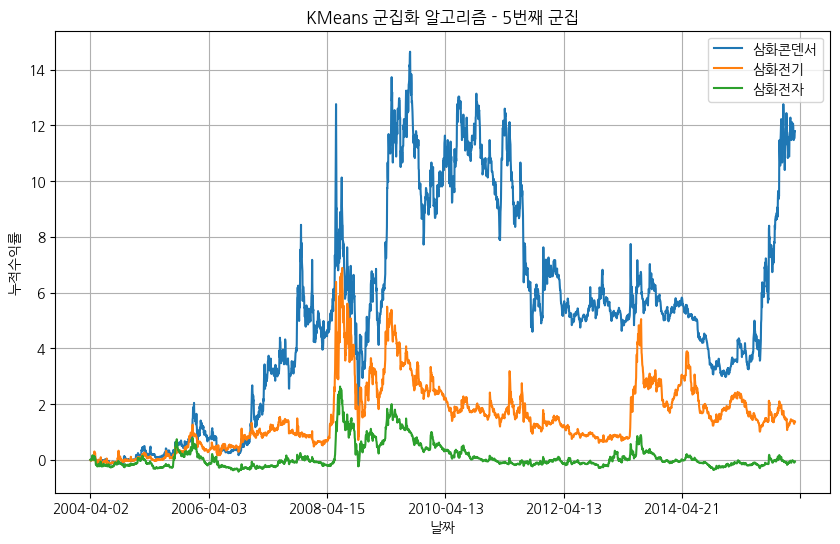

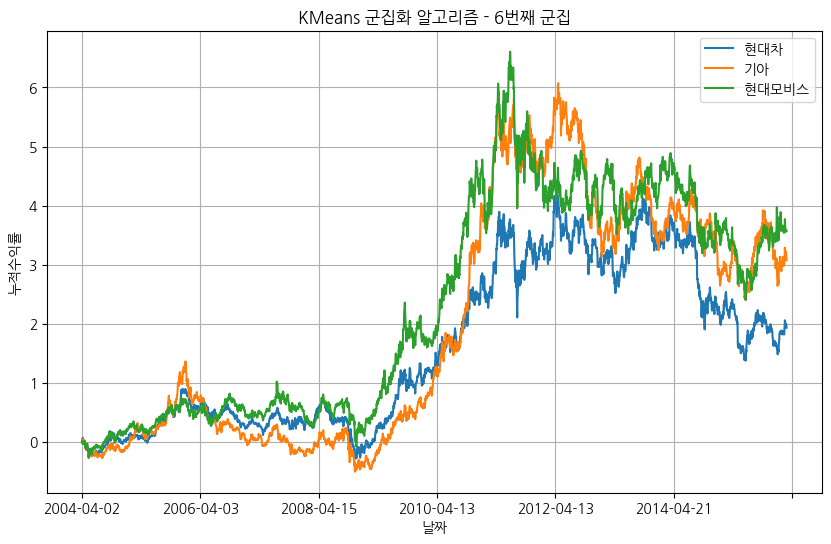

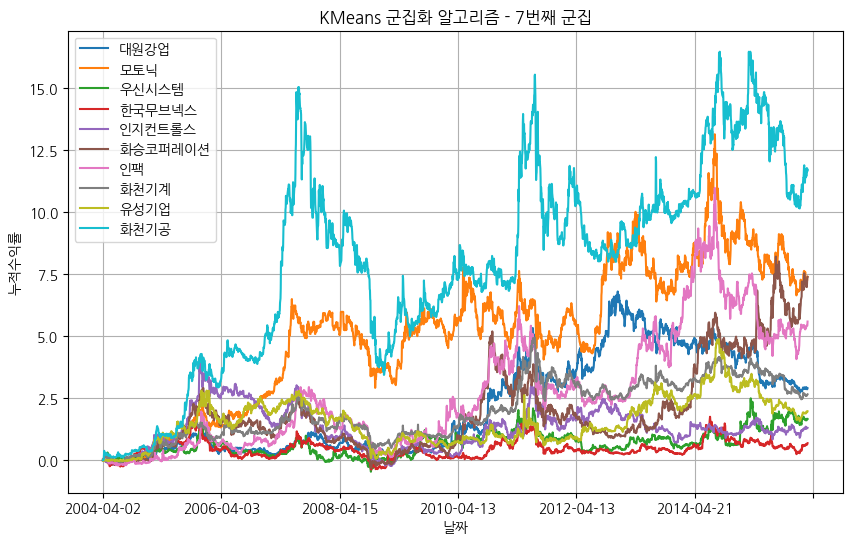

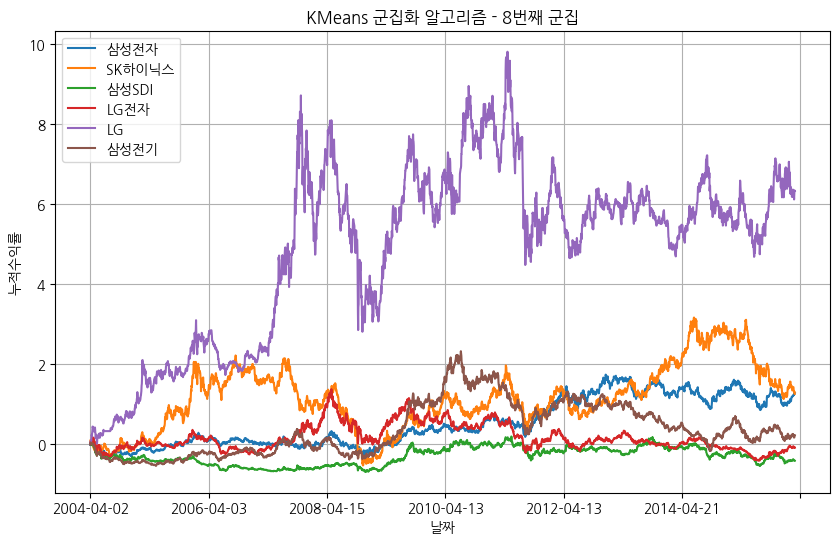

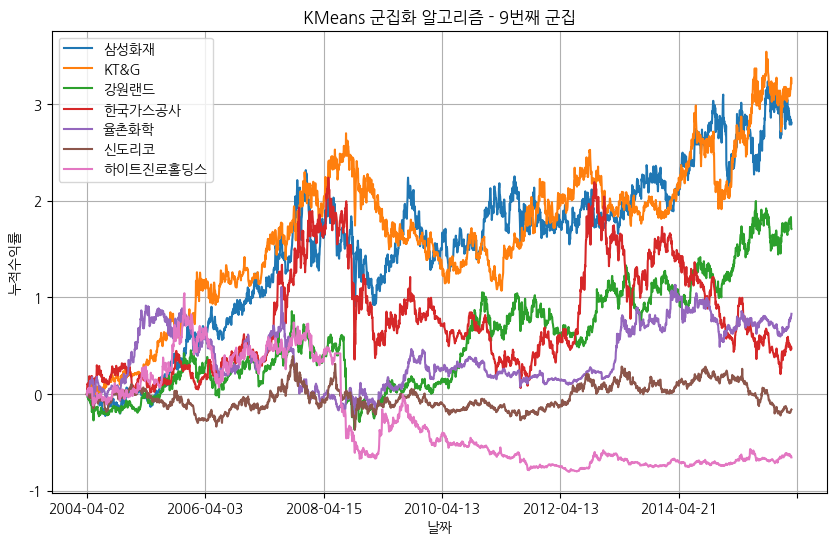

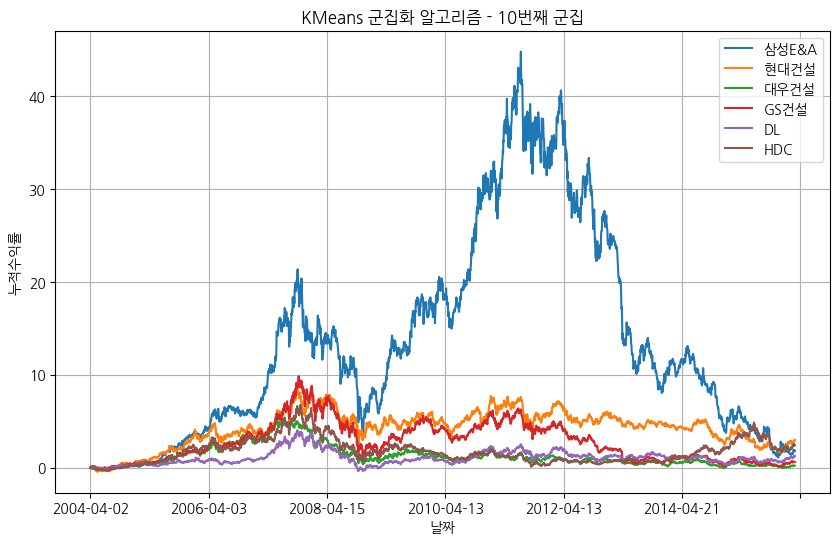

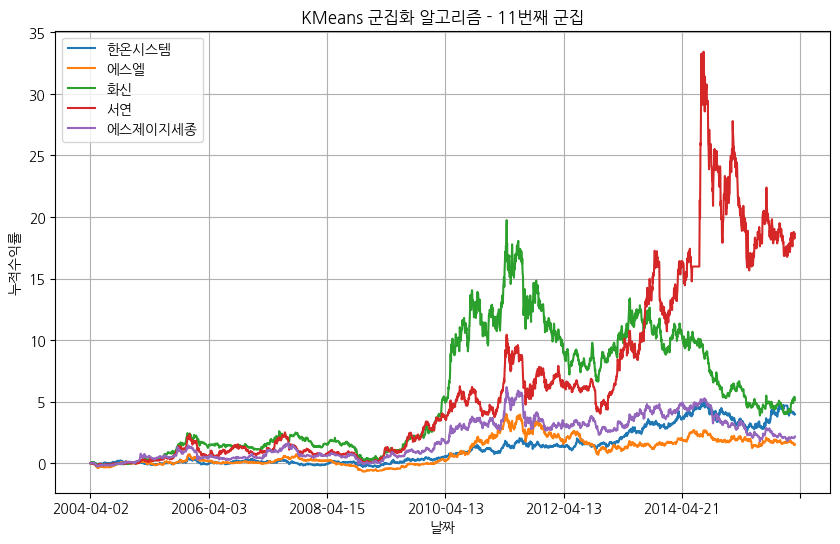

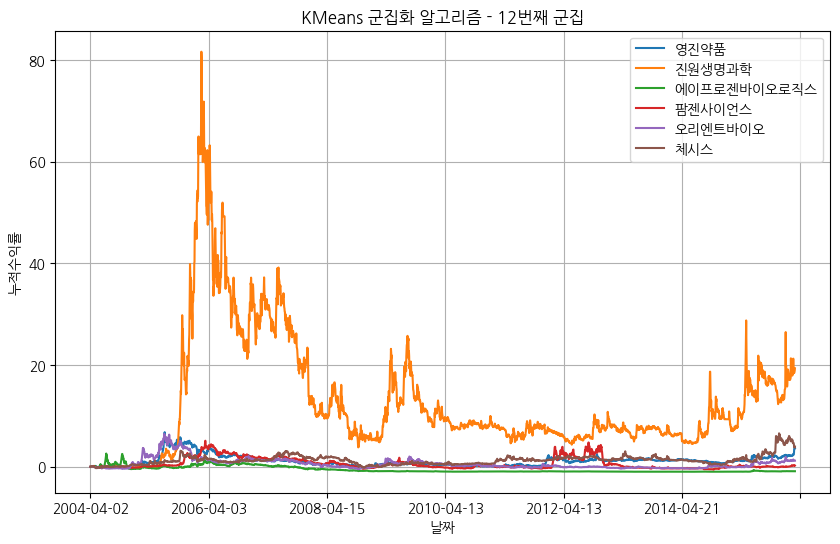

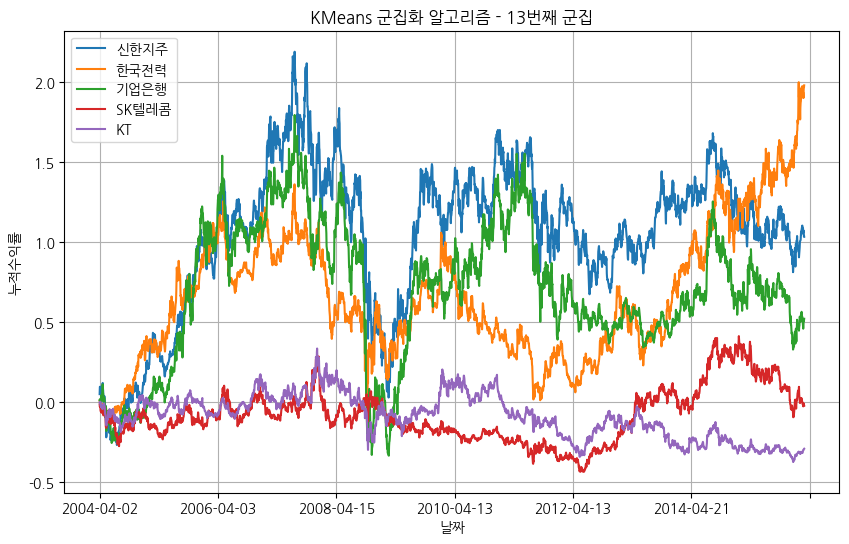

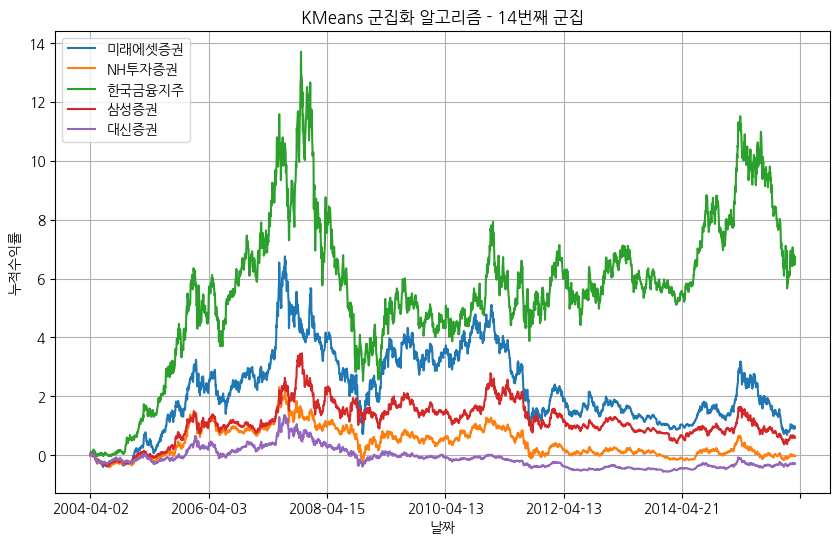

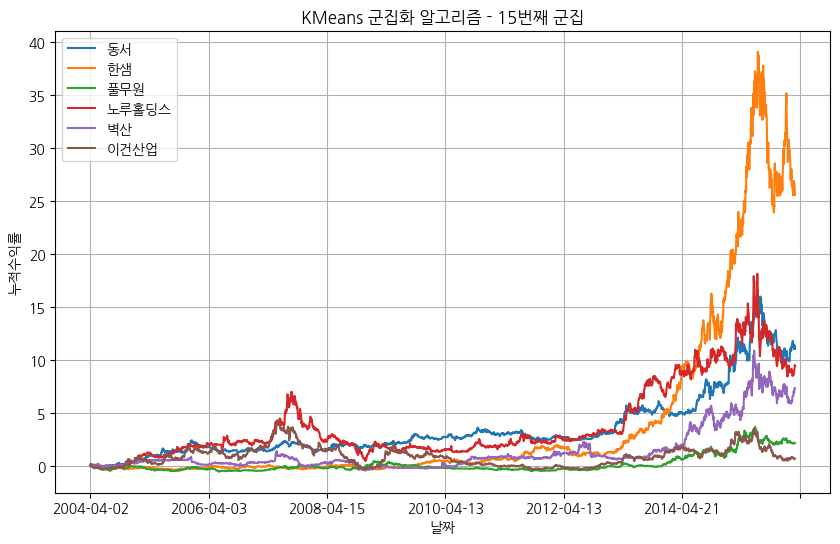

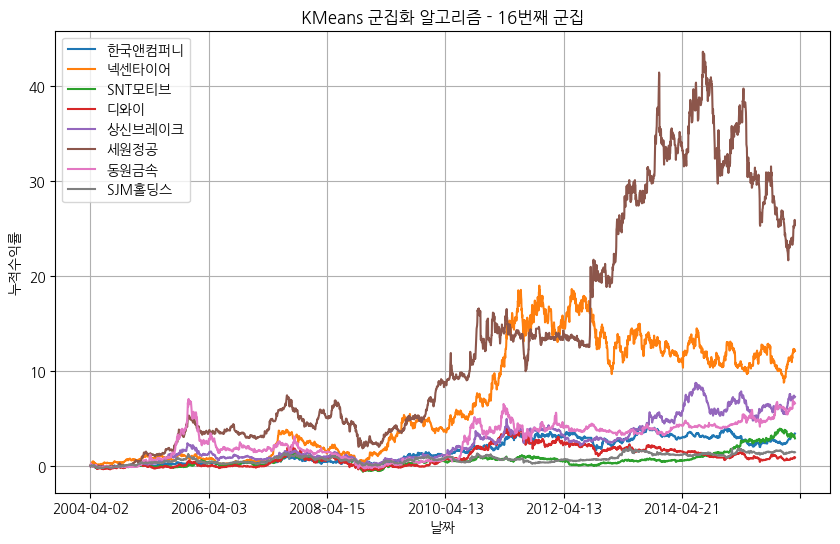

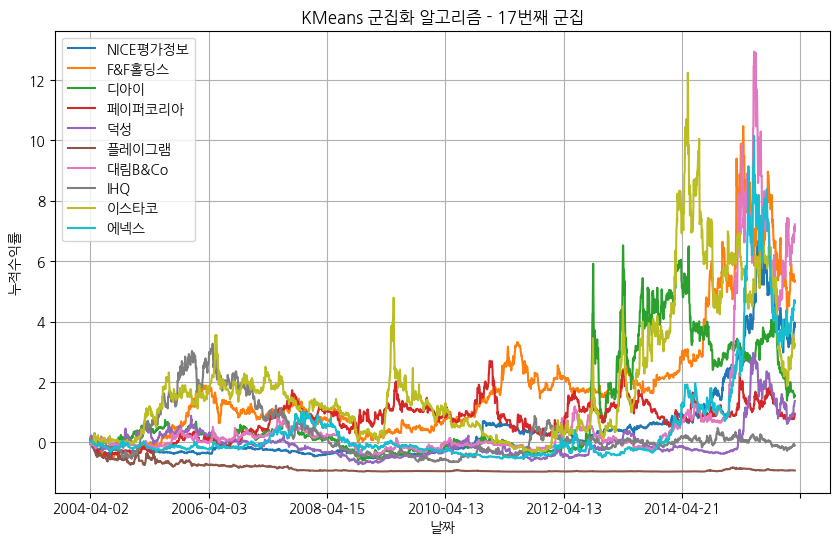

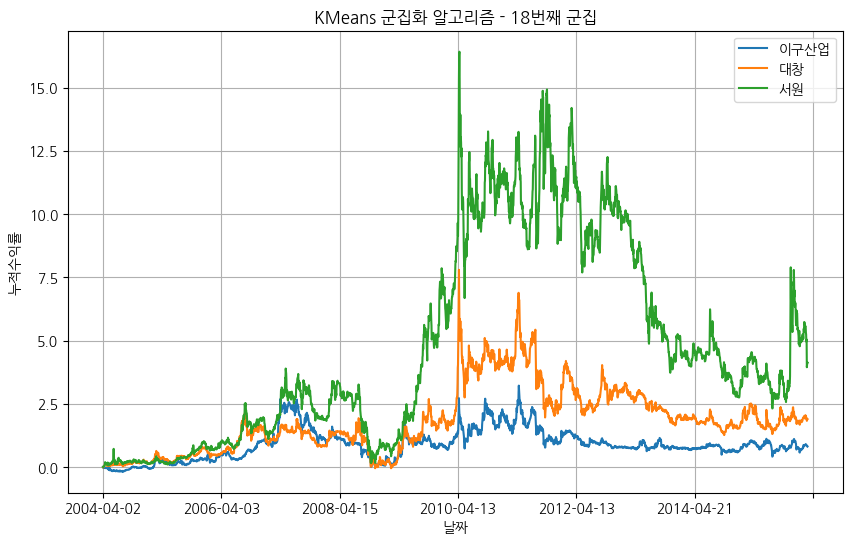

In [197]:
clusterCumsumPlot("KMeans")

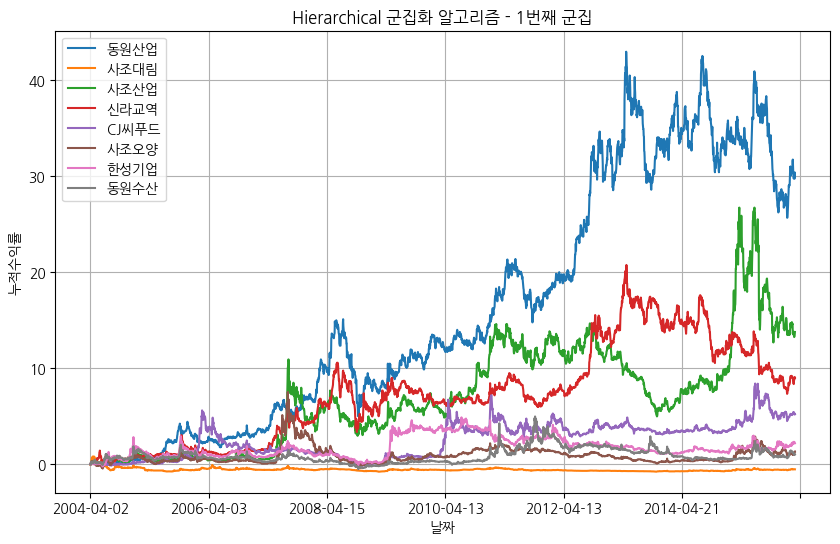

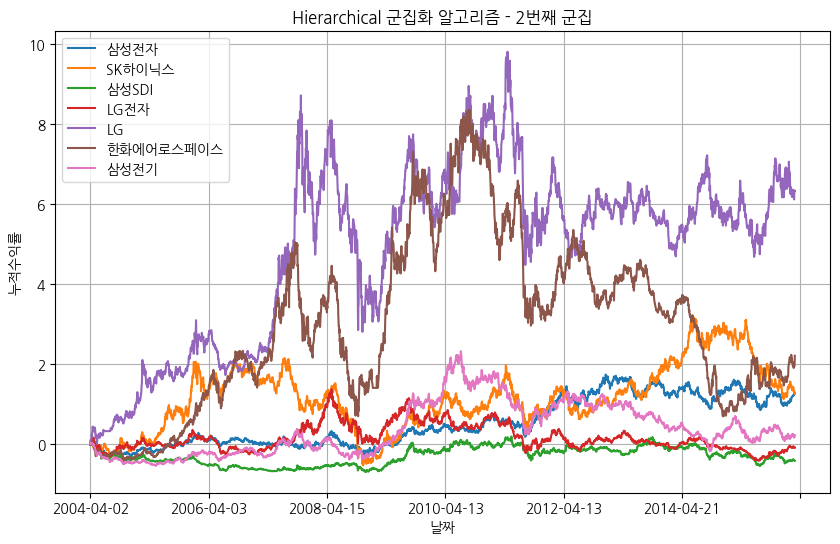

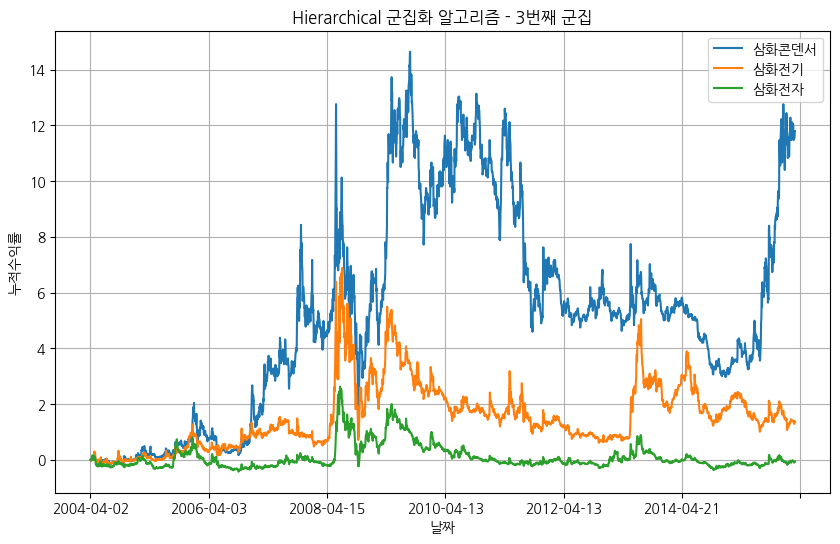

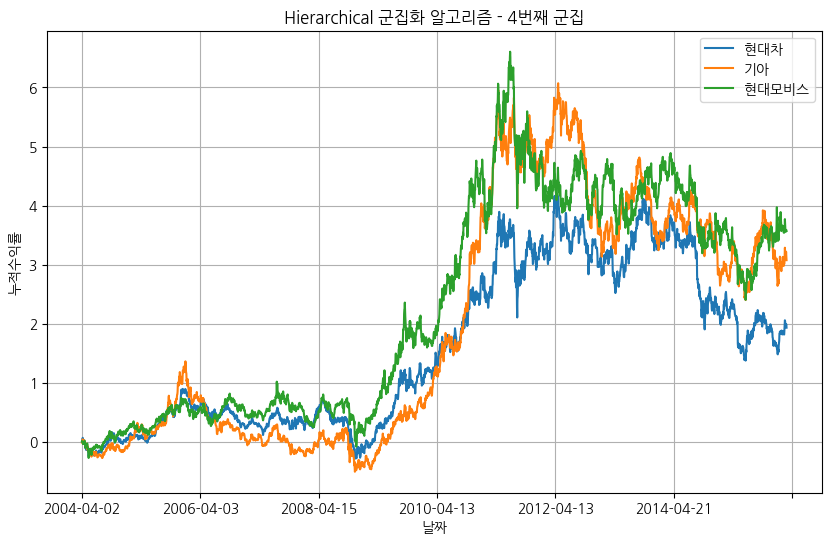

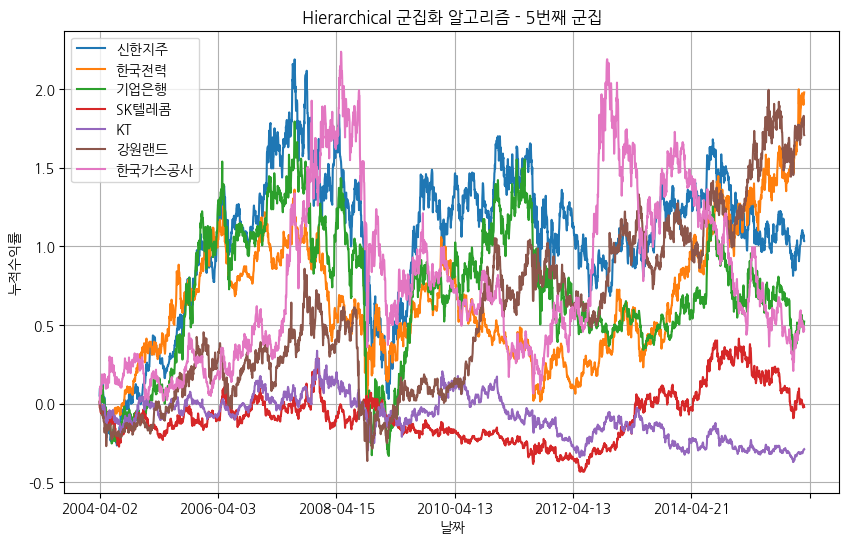

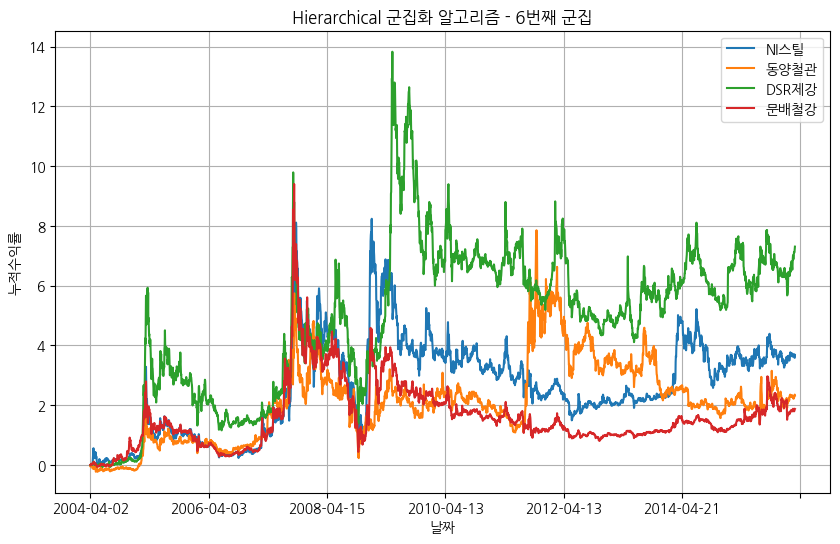

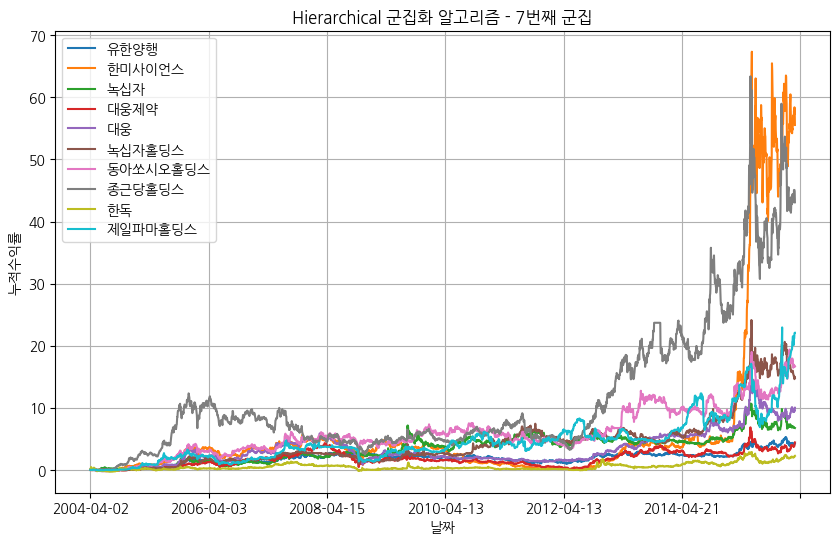

In [198]:
clusterCumsumPlot("Hierarchical")

## 4. Validation

In [199]:
val_log_returns = np.log(val_data / val_data.shift(1))
val_log_returns = val_log_returns.dropna(axis=0)

In [200]:
val_log_returns 

0                삼성전자    SK하이닉스       현대차        기아  POSCO홀딩스     NAVER   
Symbol Name                                                               
2004-04-02  -0.017544  0.008000 -0.001925 -0.012739  0.027652  0.036917  \
2004-04-06   0.051736  0.091318  0.026618  0.021142  0.000000  0.024600   
2004-04-07   0.008368  0.000000  0.029577  0.028868  0.020990  0.017527   
2004-04-08   0.008299 -0.018349  0.010870  0.004057  0.040703 -0.012062   
2004-04-09  -0.016667  0.007380 -0.023702 -0.041328  0.008511  0.017433   
...               ...       ...       ...       ...       ...       ...   
2019-03-25  -0.022815 -0.042960 -0.028749 -0.020499 -0.023439 -0.007905   
2019-03-26  -0.005510 -0.002747 -0.012579  0.008837  0.005911  0.003960   
2019-03-27   0.002208  0.009583  0.000000  0.014556  0.001963 -0.028058   
2019-03-28  -0.011087 -0.015100  0.008403 -0.004345 -0.001963 -0.008163   
2019-03-29  -0.004469  0.025940  0.000000  0.025789 -0.005911  0.016261   

0               삼성SDI      LG화학      신한지주     현대모비스  ...        신풍      동원수산   
Symbol Name                                          ...                       
2004-04-02   0.000000 -0.005434  0.049376  0.010949  ... -0.004283 -0.031416  \
2004-04-06   0.023461  0.017996  0.042665 -0.001817  ... -0.012959 -0.059163   
2004-04-07  -0.011662 -0.008951  0.000000 -0.018349  ...  0.000000  0.138878   
2004-04-08   0.008759 -0.014496  0.000000  0.005540  ... -0.010929  0.125394   
2004-04-09  -0.032499 -0.012862 -0.011052 -0.031808  ... -0.004405 -0.123432   
...               ...       ...       ...       ...  ...       ...       ...   
2019-03-25  -0.025975 -0.033493 -0.006961 -0.030772  ... -0.011215 -0.033394   
2019-03-26   0.002389 -0.001363 -0.004667  0.011948  ...  0.003752  0.000000   
2019-03-27   0.002384 -0.010974  0.000000 -0.011948  ...  0.003738 -0.004695   
2019-03-28   0.007117 -0.004147 -0.016510  0.004796  ... -0.011257 -0.014218   
2019-03-29   0.014085  0.013755 -0.001190 -0.002395  ...  0.018692 -0.001194   

0             제이준코스메틱      금호전기      한국주강     한솔PNS        한창       SHD   
Symbol Name                                                               
2004-04-02  -0.010309  0.016872 -0.046437  0.015905 -0.049795  0.028492  \
2004-04-06   0.015424  0.034803  0.035911  0.022750  0.139482 -0.016084   
2004-04-07  -0.005115  0.033653  0.069816  0.029758  0.128025 -0.010329   
2004-04-08   0.017790  0.043178  0.057524 -0.022076 -0.124835  0.024389   
2004-04-09  -0.005051  0.051476  0.024541 -0.030433 -0.065473 -0.018178   
...               ...       ...       ...       ...       ...       ...   
2019-03-25  -0.014390 -0.005676 -0.047165  0.014235  0.086120 -0.008969   
2019-03-26  -0.004838 -0.032790  0.022473  0.000000  0.020849  0.002225   
2019-03-27  -0.014671  0.009756 -0.005571  0.007042 -0.012826  0.013394   
2019-03-28  -0.004941 -0.023577  0.005571  0.006993 -0.022692 -0.004445   
2019-03-29  -0.004958 -0.020081  0.040822 -0.010508  0.244913 -0.004465   

0               비케이탑스      일정실업  
Symbol Name                      
2004-04-02   0.015248  0.000000  
2004-04-06   0.007518  0.007001  
2004-04-07   0.007462  0.003482  
2004-04-08   0.034143  0.006928  
2004-04-09  -0.021791  0.020559  
...               ...       ...  
2019-03-25  -0.004596  0.002599  
2019-03-26   0.006898  0.002548  
2019-03-27  -0.042073  0.012644  
2019-03-28   0.007144 -0.002516  
2019-03-29  -0.021563 -0.025560  

[3710 rows x 523 columns]

In [201]:
val_log_returns[groups["KMeans"][0]]

0                  영풍      태광산업       아세아  KISCO홀딩스     CR홀딩스      대한제분   
Symbol Name                                                               
2004-04-02   0.000000 -0.003617  0.022332  0.022941  0.004218  0.027956  \
2004-04-06   0.000000  0.007220  0.000000  0.018991 -0.026441  0.002503   
2004-04-07   0.000000 -0.003604  0.004719  0.009589  0.022223 -0.002503   
2004-04-08   0.000000 -0.003617  0.001588  0.021579 -0.008915  0.003752   
2004-04-09   0.000000  0.003617 -0.015813 -0.050159 -0.026795  0.023443   
...               ...       ...       ...       ...       ...       ...   
2019-03-25  -0.002418 -0.002410 -0.020041 -0.014815 -0.006105 -0.013210   
2019-03-26  -0.017094  0.009006  0.024001  0.007435  0.003644 -0.005333   
2019-03-27   0.003688 -0.026038  0.007874 -0.003711 -0.001174  0.007989   
2019-03-28  -0.013589 -0.019202 -0.003929 -0.011215 -0.001176  0.013175   
2019-03-29  -0.004988  0.011812  0.000000  0.011215  0.003640 -0.007884   

0              KPX케미칼        경방  
Symbol Name                      
2004-04-02  -0.025722  0.000000  
2004-04-06  -0.003068  0.003787  
2004-04-07  -0.007731  0.033944  
2004-04-08   0.006173  0.016669  
2004-04-09   0.034835 -0.016669  
...               ...       ...  
2019-03-25  -0.031281 -0.063975  
2019-03-26   0.024009  0.020803  
2019-03-27   0.000000 -0.009852  
2019-03-28   0.000000 -0.009950  
2019-03-29   0.001823  0.004988  

[3710 rows x 8 columns]

In [202]:
def get_r_squared(group):
    df = val_log_returns[group]
    corr = df.corr() # Correlation matrix
    corr.values[np.tril_indices_from(corr)] = np.nan # Keep only upper triangular of the correlation matrix
    return corr.unstack().mean() # Return mean of the correlation matrix


def average_correlation(groups):
    avg_corr = {}
    for algorithm, cluster_result in groups.items():
        corrs = []
        for group in cluster_result:
            corr = get_r_squared(group)
            corrs.append(corr)
        avg_corr[algorithm] = np.mean(np.square(corrs)) # Take mean of r-squared 
    return avg_corr

corr_metrics = average_correlation(groups)
pd.DataFrame(corr_metrics.items(), columns=["Algorithm", "R-Squared"])

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Algorithm  R-Squared
0        KMeans   0.153974
1        DBSCAN        NaN
2  Hierarchical   0.199904

In [203]:
from sklearn.metrics import silhouette_score

def prepare_labels(data, groups):
    # Prepare a mapping from stock names to their positions to align labels
    stock_indices = {stock: index for index, stock in enumerate(data.columns)}
    
    # Prepare labels for each algorithm
    prepared_labels = {}
    for algorithm, clusters in groups.items():
        labels = [-1] * len(data.columns)  # Initialize with -1 for any potentially unassigned stocks
        for cluster_index, stocks in enumerate(clusters):
            for stock in stocks:
                if stock in stock_indices:
                    labels[stock_indices[stock]] = cluster_index
        prepared_labels[algorithm] = labels
    return prepared_labels

def calculate_silhouette_scores(data, groups):
    prepared_labels = prepare_labels(data, groups)
    silhouette_scores = {}
    for algorithm, labels in prepared_labels.items():
        # Check if labels have been properly assigned (avoid all -1 scenario)
        if len(set(labels)) > 1:
            score = silhouette_score(data.T, labels)  # Transpose to align samples with features
            silhouette_scores[algorithm] = score
        else:
            silhouette_scores[algorithm] = None  # No valid scoring if all labels are -1
    return silhouette_scores

# Assuming `groups` contains your cluster data as previously formatted
silhouette_scores = calculate_silhouette_scores(val_log_returns, groups)

# Display the results in a DataFrame
import pandas as pd
results_df = pd.DataFrame(silhouette_scores.items(), columns=["Algorithm", "Silhouette Score"])
print(results_df)


      Algorithm  Silhouette Score
0        KMeans         -0.144275
1        DBSCAN               NaN
2  Hierarchical         -0.141786


---

In [204]:
# 그냥 끄적끄적

In [205]:
DBsimul_data_raw = simul_data[groups["Hierarchical"][0]]
DBsimul_data = np.log(DBsimul_data_raw)
DBsimul_data = DBsimul_data.dropna(axis=0)

In [206]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint

# 모든 주식 페어의 공적분 검사 실행
symbols = DBsimul_data.columns
pairs = [(symbols[i], symbols[j]) for i in range(len(symbols)) for j in range(i+1, len(symbols))]
cointegration_results = []

for x, y in pairs:
    score, p_value, _ = coint(DBsimul_data[x], DBsimul_data[y])
    if p_value < 0.05:
        cointegration_results.append((x, y, p_value))

# 공적분 관계 있는 주식 페어와 p-value를 DataFrame으로 생성
cointegration_df = pd.DataFrame(cointegration_results, columns=['Stock1', 'Stock2', 'P-Value'])


In [207]:
import networkx as nx
import pandas as pd
# 그래프 생성
G = nx.from_pandas_edgelist(cointegration_df, 'Stock1', 'Stock2', ['P-Value'])

def is_bipartite_graph(graph):
    try:
        # 이분 그래프인지 확인
        color = nx.bipartite.color(graph)
        return True, color
    except nx.NetworkXError:
        return False, None

def remove_edges_to_bipartite(graph):
    sorted_edges = sorted(graph.edges(data=True), key=lambda x: x[2]['P-Value'], reverse=True)
    
    for u, v, data in sorted_edges:
        # 간선 제거
        graph.remove_edge(u, v)
        # 이분 그래프 판별
        is_bipartite, color = is_bipartite_graph(graph)
        if is_bipartite:
            return True, graph
        
        # 고립된 노드 확인 및 제거
        isolated = [node for node, degree in graph.degree() if degree == 0]
        graph.remove_nodes_from(isolated)

    return False, graph

# 이분 그래프로 변환 시도
is_bipartite, bipartite_graph = remove_edges_to_bipartite(G)

# 결과 출력
is_bipartite, bipartite_graph.edges(), bipartite_graph.nodes()


(True,
 EdgeView([('사조대림', '사조산업'), ('사조대림', '신라교역'), ('사조대림', 'CJ씨푸드'), ('사조대림', '사조오양'), ('사조대림', '한성기업'), ('사조대림', '동원수산')]),
 NodeView(('사조대림', '사조산업', '신라교역', 'CJ씨푸드', '사조오양', '한성기업', '동원수산')))

In [208]:
colors = nx.bipartite.color(bipartite_graph)

# 클래스에 따라 정점을 그룹화
group_1 = [node for node, color in colors.items() if color == 1]
group_0 = [node for node, color in colors.items() if color == 0]

# 간선이 존재하는 주식 페어 추출
edges_pairs = [(u, v) for u, v in bipartite_graph.edges() if (u in group_1 and v in group_0) or (u in group_0 and v in group_1)]

# DataFrame으로 변환
edges_df = pd.DataFrame(edges_pairs, columns=['1', '0'])

edges_df_with_pvalues = edges_df.merge(cointegration_df, how='left', left_on=['1', '0'], right_on=['Stock1', 'Stock2'])

# 필요한 칼럼만 선택
edges_df_with_pvalues = edges_df_with_pvalues[['1', '0', 'P-Value']]

# P-Value의 역수 계산
inverse_p_values = 1 / edges_df_with_pvalues['P-Value']

# Softmax 계산
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

# Softmax 적용
weights = softmax(inverse_p_values)
edges_df_with_pvalues['Weight'] = weights
edges_df_with_pvalues

1      0   P-Value         Weight
0  사조대림   사조산업  0.002682   5.130301e-25
1  사조대림   신라교역  0.003250   2.408103e-53
2  사조대림  CJ씨푸드  0.008980  1.366943e-138
3  사조대림   사조오양  0.007062  1.857654e-125
4  사조대림   한성기업  0.002332   1.000000e+00
5  사조대림   동원수산  0.007702  1.450215e-130

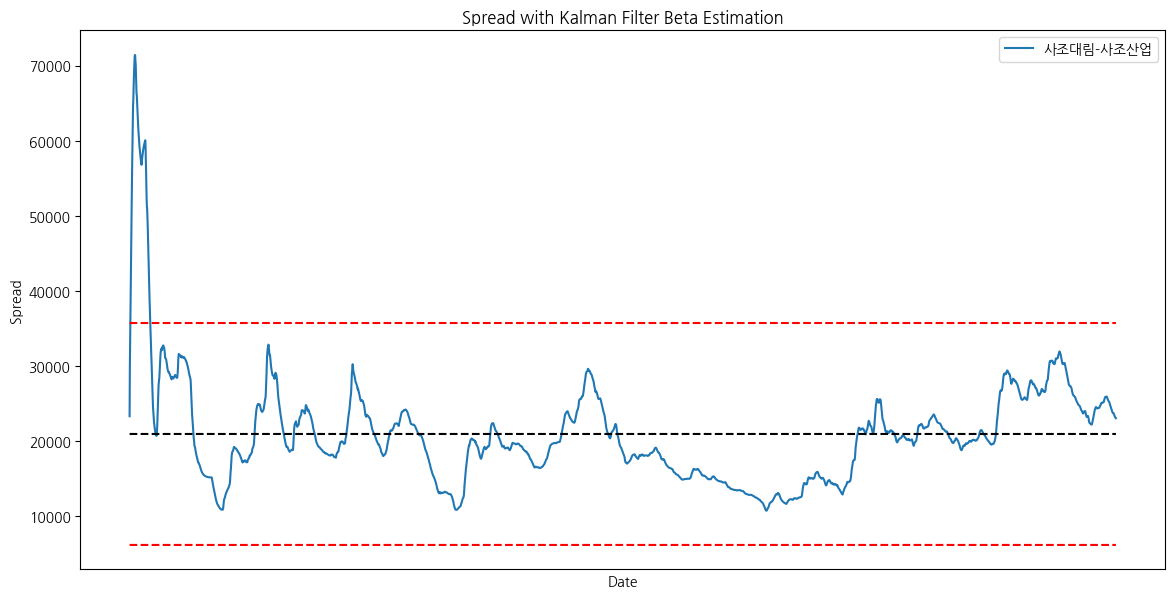

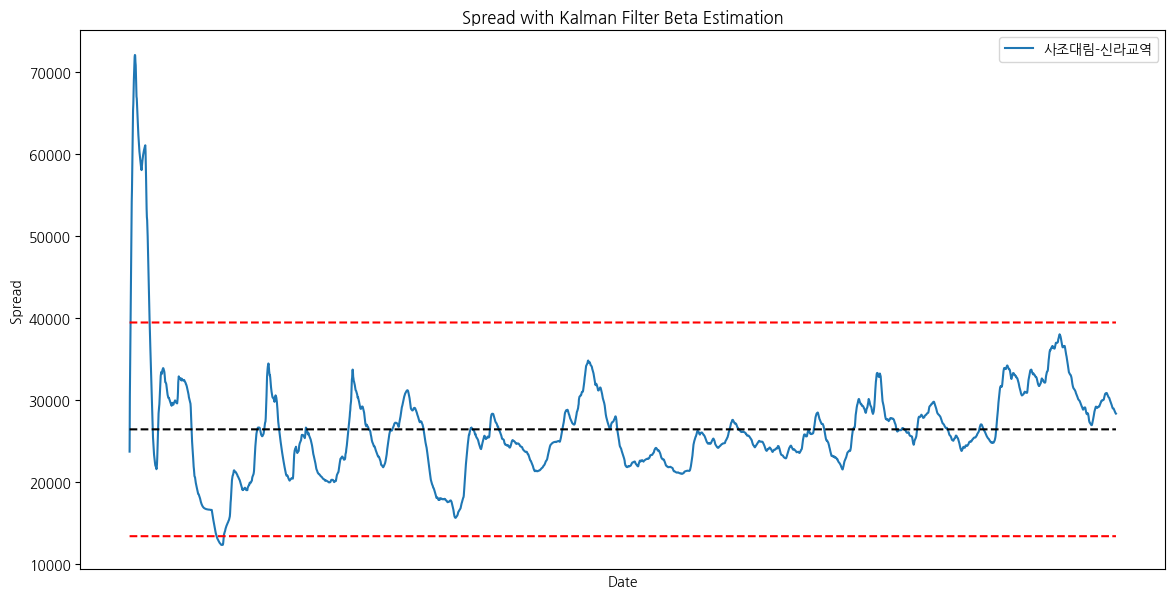

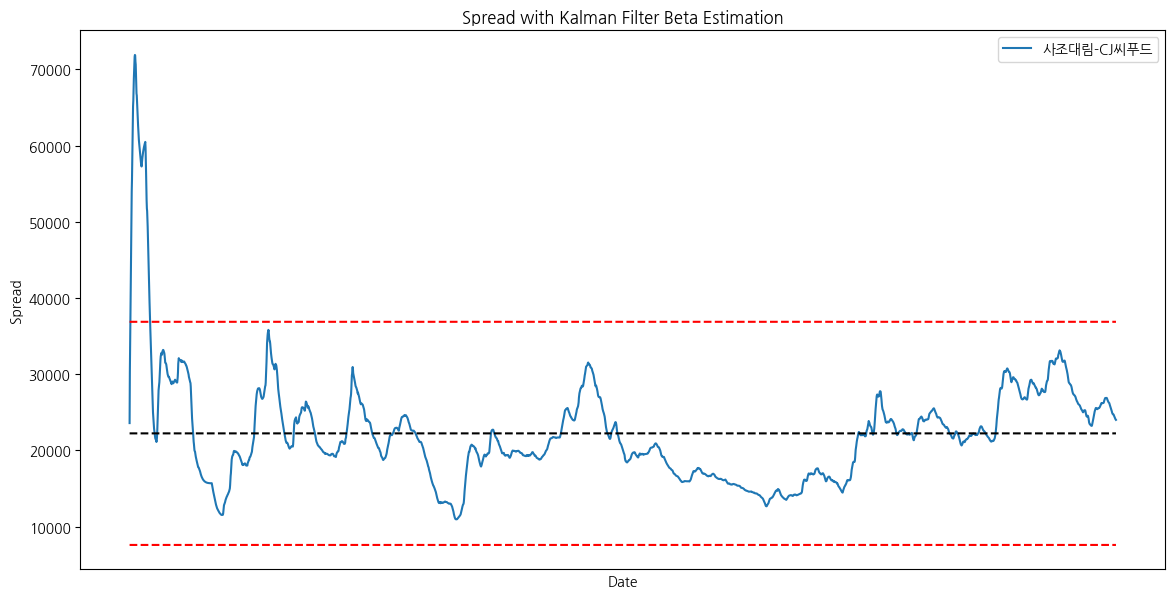

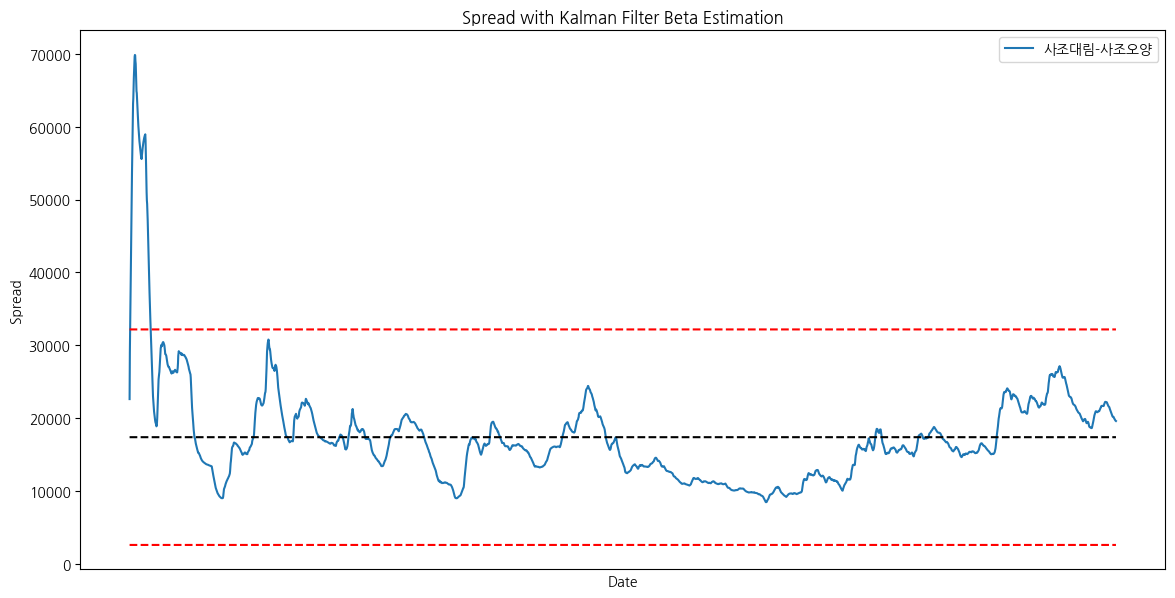

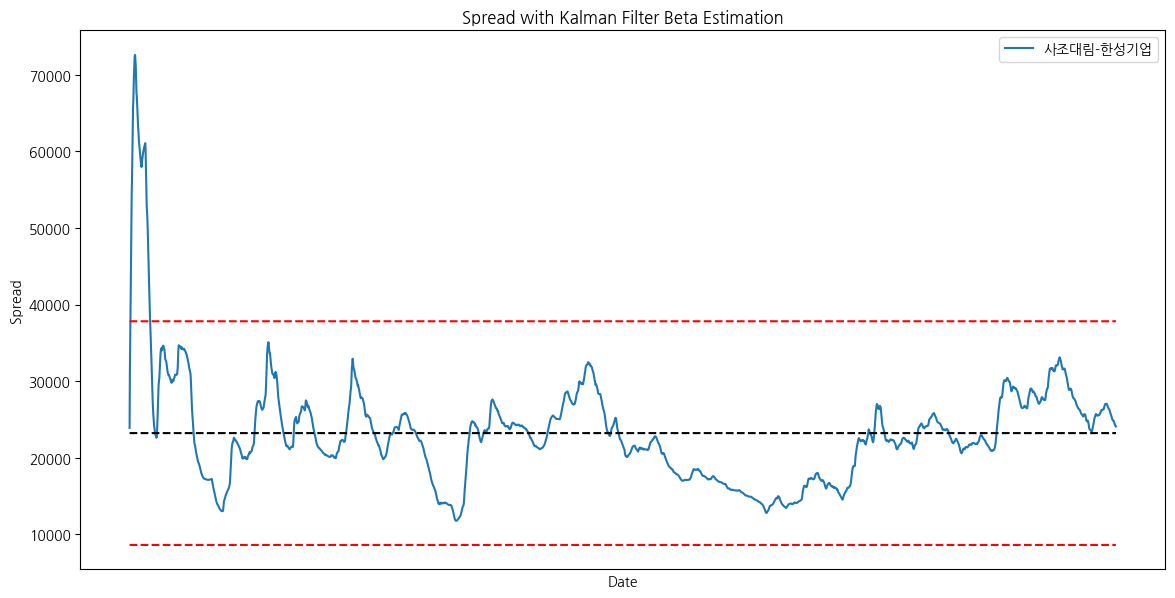

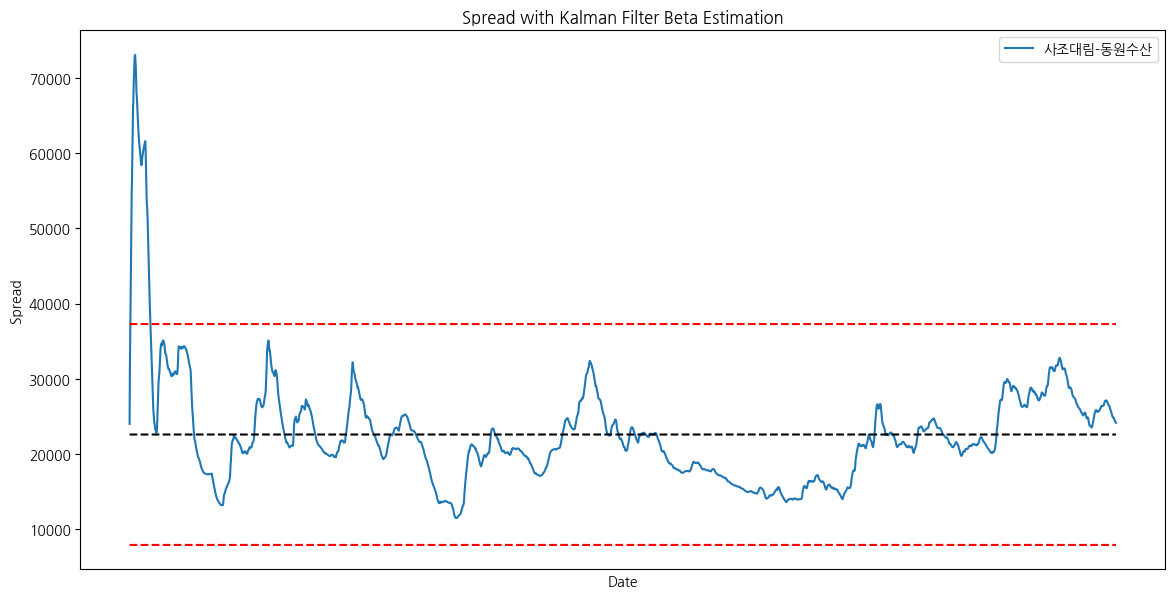

In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# 스프레드와 칼만 필터 베타 추정
spread_df = pd.DataFrame(index=DBsimul_data_raw.index)

for index, row in edges_df_with_pvalues.iterrows():
    stock1 = row['1']
    stock2 = row['0']

    # 베타 초기 추정
    beta = np.cov(DBsimul_data_raw[stock1], DBsimul_data_raw[stock2])[0, 1] / np.var(DBsimul_data_raw[stock2])
    
    # 스프레드 계산
    spread = DBsimul_data_raw[stock1] - beta * DBsimul_data_raw[stock2]
    
    # 칼만 필터로 베타 동적 추정
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=beta,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    
    mean, _ = kf.filter(spread.values)
    filtered_spread = mean.flatten()
    
    # 데이터 저장
    spread_df[stock1 + '-' + stock2] = filtered_spread

spread_stats_df = pd.DataFrame({
    'Mean': spread_df.mean(),
    'Std': spread_df.std()
})

# 스프레드 시각화
for column in spread_df.columns:
    plt.figure(figsize=(14, 7))
    plt.xticks([])
    plt.plot(spread_df.index, spread_df[column], label=column)
    plt.legend()
    plt.plot(spread_df.index, [spread_stats_df.at[column, 'Mean']] * len(spread_df), 'k--', label=f'Mean of {column}')
    plt.plot(spread_df.index, [spread_stats_df.at[column, 'Mean'] + 2 * spread_stats_df.at[column, 'Std']] * len(spread_df), 'r--', label=f'+2 Std of {column}')
    plt.plot(spread_df.index, [spread_stats_df.at[column, 'Mean'] - 2 * spread_stats_df.at[column, 'Std']] * len(spread_df), 'r--', label=f'-2 Std of {column}')
    plt.title("Spread with Kalman Filter Beta Estimation")
    plt.xlabel("Date")
    plt.ylabel("Spread")
    plt.show()


In [210]:
edges_df_with_pvalues

1      0   P-Value         Weight
0  사조대림   사조산업  0.002682   5.130301e-25
1  사조대림   신라교역  0.003250   2.408103e-53
2  사조대림  CJ씨푸드  0.008980  1.366943e-138
3  사조대림   사조오양  0.007062  1.857654e-125
4  사조대림   한성기업  0.002332   1.000000e+00
5  사조대림   동원수산  0.007702  1.450215e-130

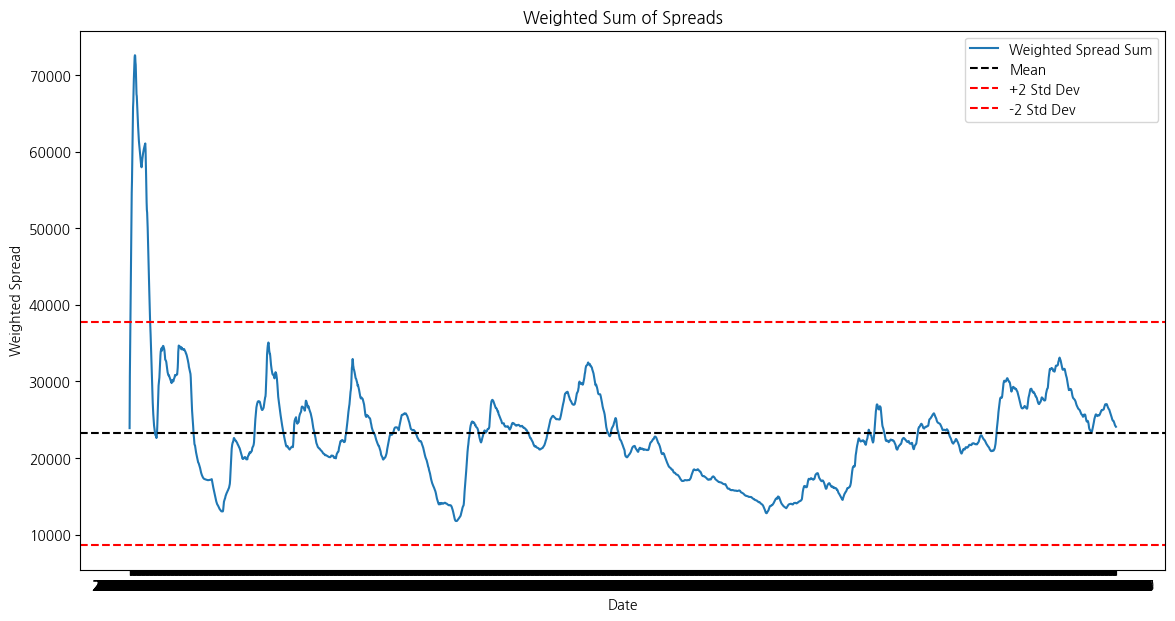

In [211]:
# 가중치를 사용하여 스프레드 합 계산
weighted_spread = pd.Series(0, index=spread_df.index)
for index, row in edges_df_with_pvalues.iterrows():
    stock_pair = row['1'] + '-' + row['0']
    weight = row['Weight']
    weighted_spread += spread_df[stock_pair] * weight

weighted_spread_mean = weighted_spread.mean()
weighted_spread_std = weighted_spread.std()

# 가중합 스프레드 시각화
plt.figure(figsize=(14, 7))
plt.plot(weighted_spread.index, weighted_spread, label='Weighted Spread Sum')
plt.axhline(weighted_spread_mean, color='k', linestyle='--', label='Mean')
plt.axhline(weighted_spread_mean + 2 * weighted_spread_std, color='r', linestyle='--', label='+2 Std Dev')
plt.axhline(weighted_spread_mean - 2 * weighted_spread_std, color='r', linestyle='--', label='-2 Std Dev')
plt.title("Weighted Sum of Spreads")
plt.xlabel("Date")
plt.ylabel("Weighted Spread")
plt.legend()
plt.show()

## Test

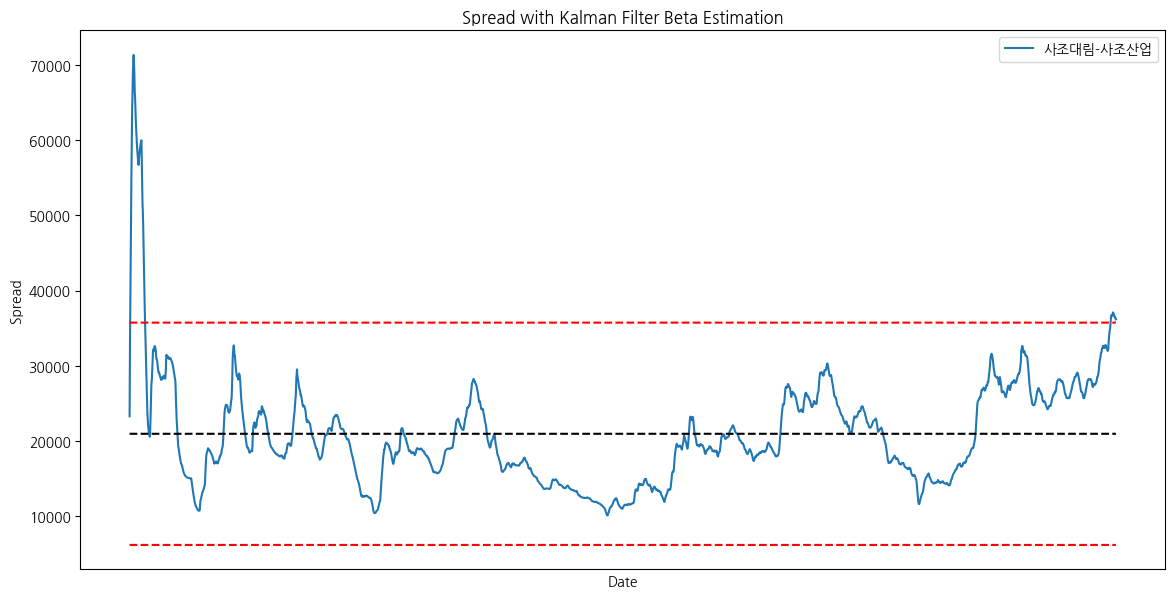

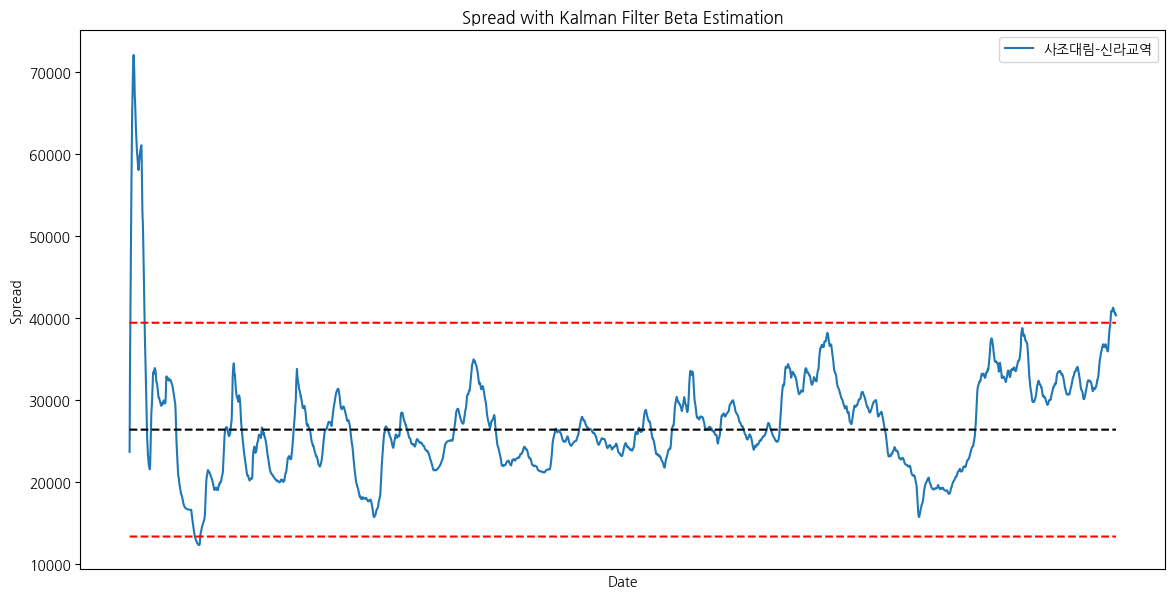

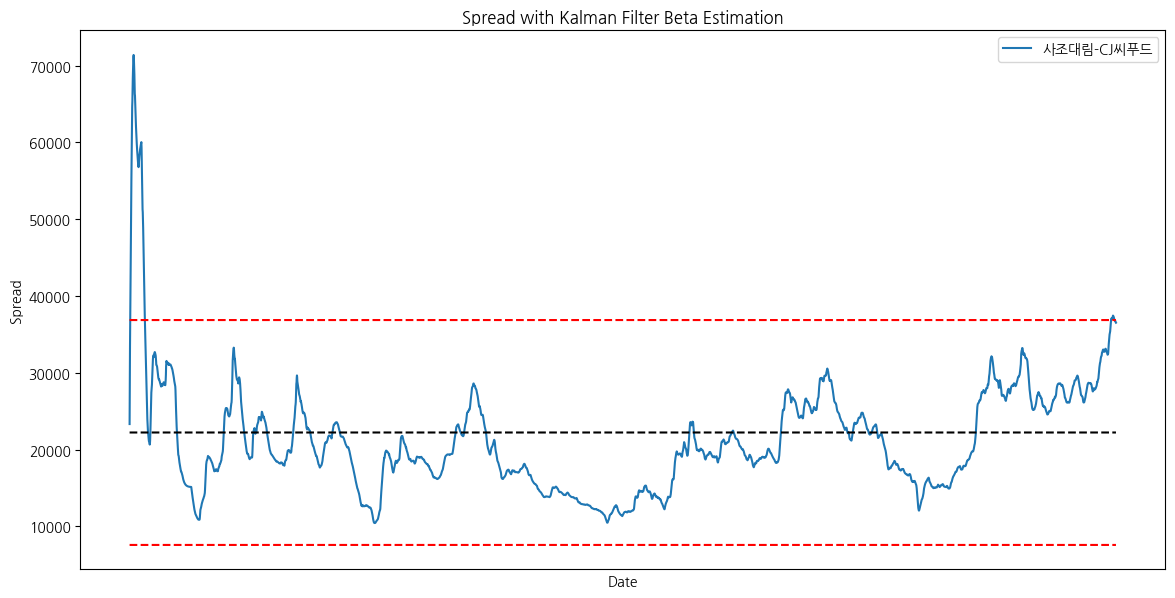

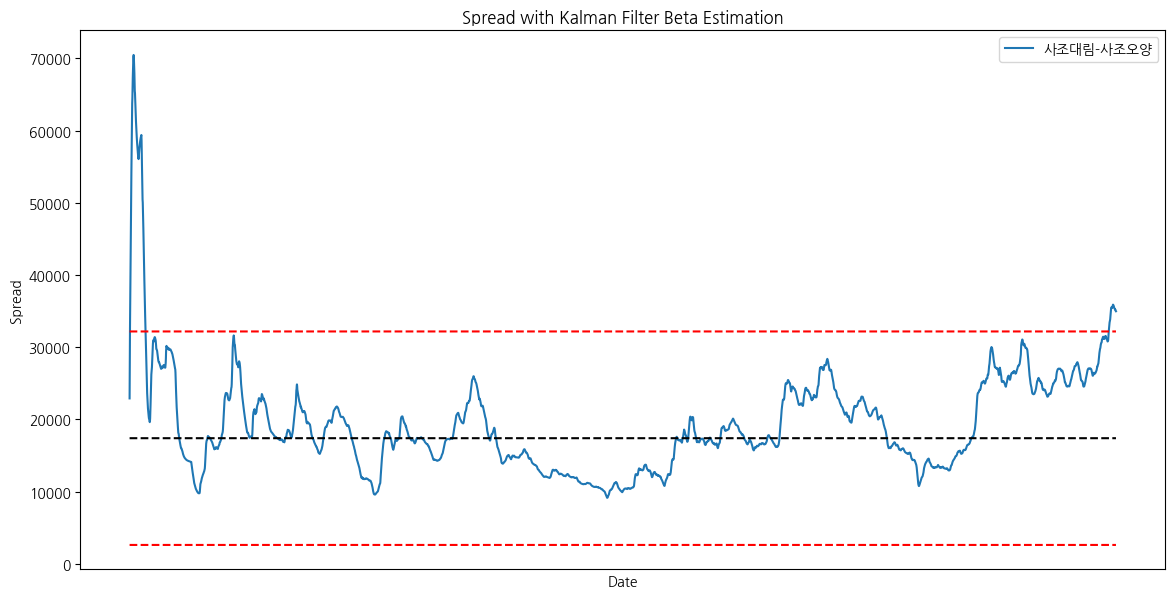

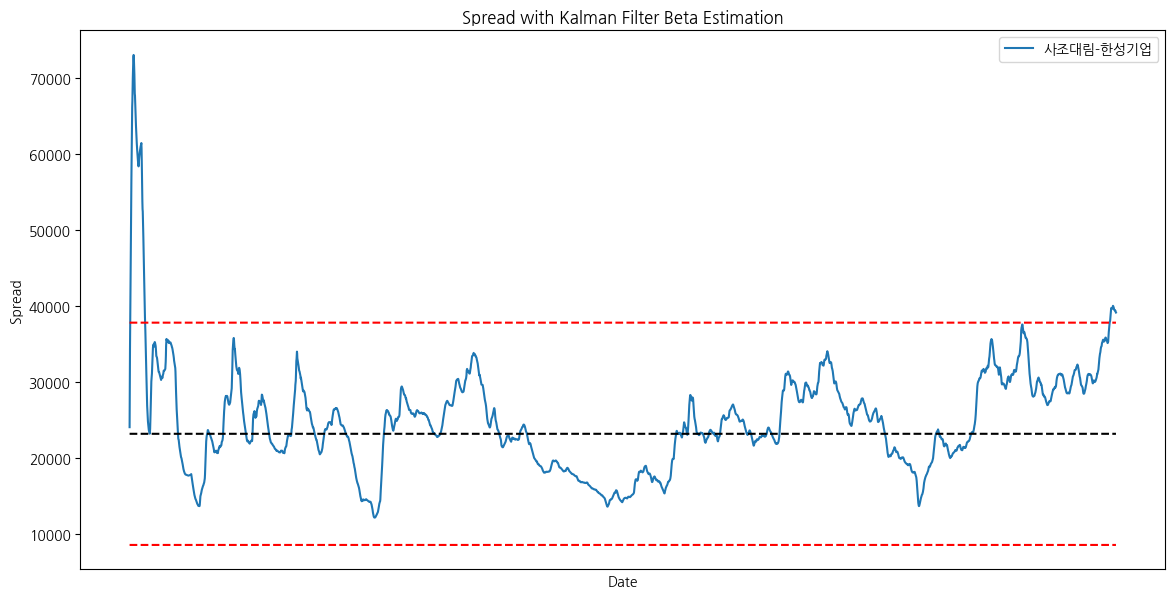

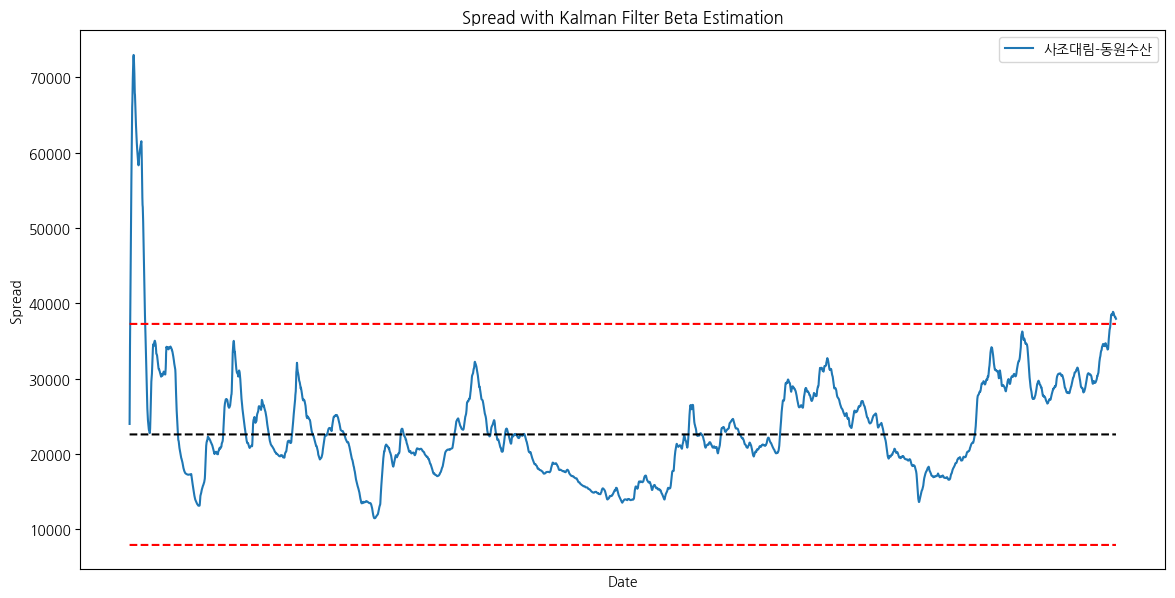

In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# 스프레드와 칼만 필터 베타 추정
spread_df_test = pd.DataFrame(index=total_data.index)

for index, row in edges_df_with_pvalues.iterrows():
    stock1 = row['1']
    stock2 = row['0']

    # 베타 초기 추정
    beta = np.cov(total_data[stock1], total_data[stock2])[0, 1] / np.var(total_data[stock2])
    
    # 스프레드 계산
    spread = total_data[stock1] - beta * total_data[stock2]
    
    # 칼만 필터로 베타 동적 추정
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=beta,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    
    mean, _ = kf.filter(spread.values)
    filtered_spread = mean.flatten()
    
    # 데이터 저장
    spread_df_test[stock1 + '-' + stock2] = filtered_spread

# 스프레드 시각화
for column in spread_df.columns:
    plt.figure(figsize=(14, 7))
    plt.xticks([])
    plt.plot(spread_df_test.index, spread_df_test[column], label=column)
    plt.legend()
    plt.plot(spread_df_test.index, [spread_stats_df.at[column, 'Mean']] * len(spread_df_test), 'k--', label=f'Mean of {column}')
    plt.plot(spread_df_test.index, [spread_stats_df.at[column, 'Mean'] + 2 * spread_stats_df.at[column, 'Std']] * len(spread_df_test), 'r--', label=f'+2 Std of {column}')
    plt.plot(spread_df_test.index, [spread_stats_df.at[column, 'Mean'] - 2 * spread_stats_df.at[column, 'Std']] * len(spread_df_test), 'r--', label=f'-2 Std of {column}')
    plt.title("Spread with Kalman Filter Beta Estimation")
    plt.xlabel("Date")
    plt.ylabel("Spread")
    plt.show()

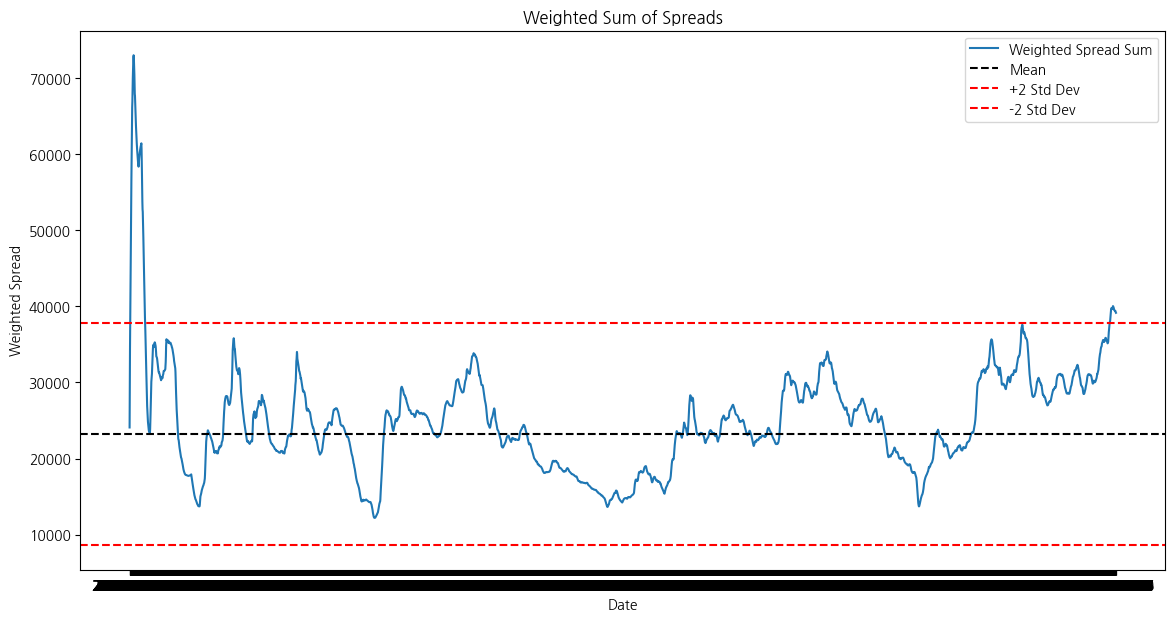

In [216]:
# 가중치를 사용하여 스프레드 합 계산
weighted_spread_test = pd.Series(0, spread_df_test.index)
for index, row in edges_df_with_pvalues.iterrows():
    stock_pair = row['1'] + '-' + row['0']
    weight = row['Weight']
    weighted_spread_test += spread_df_test[stock_pair] * weight

# 가중합 스프레드 시각화
plt.figure(figsize=(14, 7))
plt.plot(weighted_spread_test.index, weighted_spread_test, label='Weighted Spread Sum')
plt.axhline(weighted_spread_mean, color='k', linestyle='--', label='Mean')
plt.axhline(weighted_spread_mean + 2 * weighted_spread_std, color='r', linestyle='--', label='+2 Std Dev')
plt.axhline(weighted_spread_mean - 2 * weighted_spread_std, color='r', linestyle='--', label='-2 Std Dev')
plt.title("Weighted Sum of Spreads")
plt.xlabel("Date")
plt.ylabel("Weighted Spread")
plt.legend()
plt.show()

---

In [ ]:
from arch.unitroot import engle_granger

eg_test = engle_granger(DBsimul_data["삼화전자"], DBsimul_data["삼화전기"], trend="c")
eg_test

Engle-Granger Cointegration Test
Statistic: -3.588733292142027
P-value: 0.02565125107466208
Null: No Cointegration, Alternative: Cointegration
ADF Lag length: 0
Trend: c
Estimated Root ρ (γ+1): 0.9925441988662974
Distribution Order: 1
ID: 0x1f51f395010

In [ ]:
DBsimul_data['Spread'] = DBsimul_data['삼화전자'] - 0.993 * DBsimul_data['삼화전기']

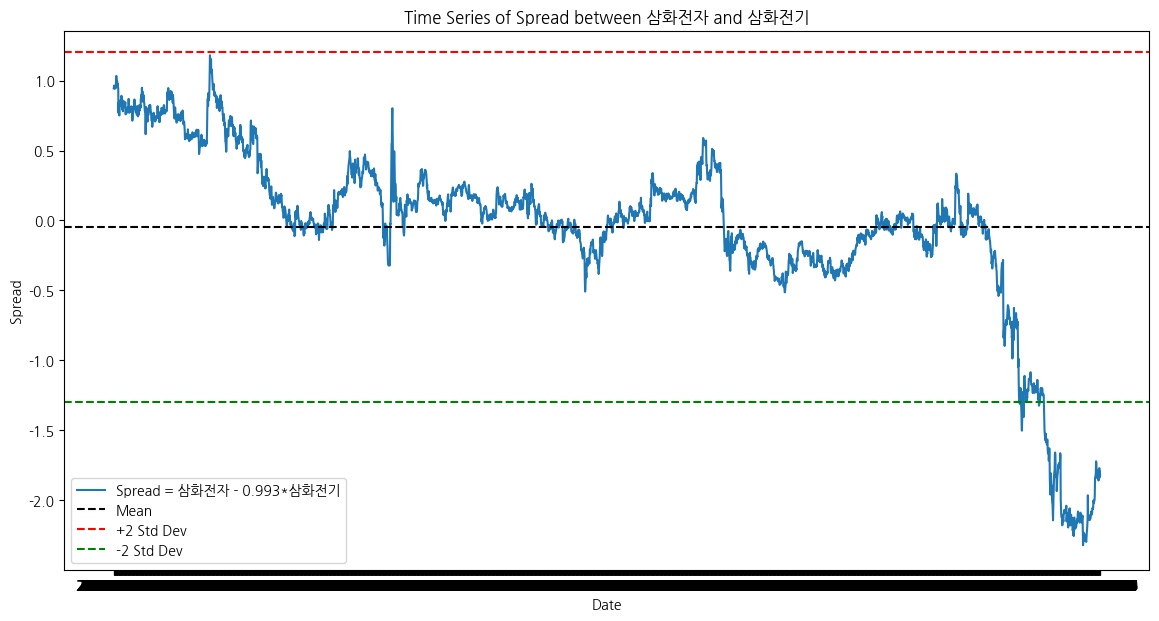

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 스프레드의 평균과 표준편차 계산
mean_spread = DBsimul_data['Spread'].mean()
std_spread = DBsimul_data['Spread'].std()

# 시각화
plt.figure(figsize=(14, 7))
plt.plot(DBsimul_data['Spread'], label='Spread = 삼화전자 - 0.993*삼화전기')
plt.title('Time Series of Spread between 삼화전자 and 삼화전기')
plt.xlabel('Date')
plt.ylabel('Spread')

# 평균선과 표준편차선 추가
plt.axhline(y=mean_spread, color='k', linestyle='--', label='Mean')
plt.axhline(y=mean_spread + 2*std_spread, color='r', linestyle='--', label='+2 Std Dev')
plt.axhline(y=mean_spread - 2*std_spread, color='g', linestyle='--', label='-2 Std Dev')

plt.legend()
plt.show()


In [ ]:
total_data

DBsimul_data_total = total_data[groups["DBSCAN"][0]]
DBsimul_data_total = np.log(DBsimul_data_total)
DBsimul_data_total = DBsimul_data_total.dropna(axis=0)

In [ ]:
DBsimul_data_total['Spread'] = DBsimul_data_total['삼화전자'] - 0.993 * DBsimul_data_total['삼화전기']

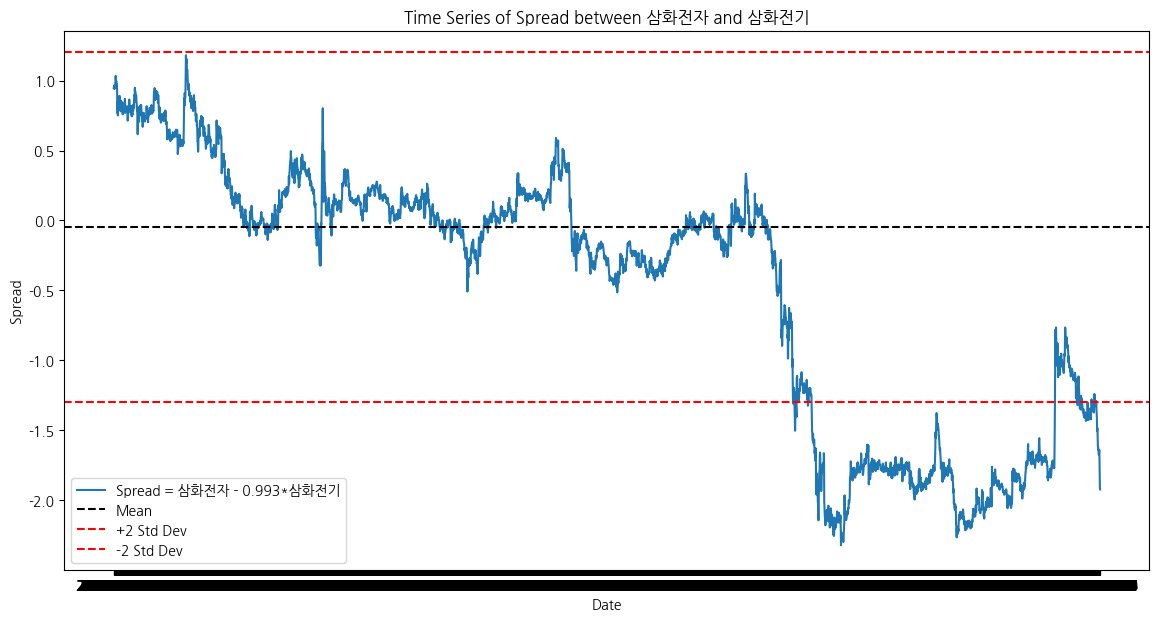

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

mean_spread = DBsimul_data['Spread'].mean()
std_spread = DBsimul_data['Spread'].std()

# 시각화
plt.figure(figsize=(14, 7))
plt.plot(DBsimul_data_total['Spread'], label='Spread = 삼화전자 - 0.993*삼화전기')
plt.title('Time Series of Spread between 삼화전자 and 삼화전기')
plt.xlabel('Date')
plt.ylabel('Spread')

# 평균선과 표준편차선 추가
plt.axhline(y=mean_spread, color='k', linestyle='--', label='Mean')
plt.axhline(y=mean_spread + 2*std_spread, color='r', linestyle='--', label='+2 Std Dev')
plt.axhline(y=mean_spread - 2*std_spread, color='r', linestyle='--', label='-2 Std Dev')


plt.legend()
plt.show()


In [ ]:
from arch.unitroot import engle_granger

eg_test = engle_granger(DBsimul_data_total["삼화전자"], DBsimul_data_total["삼화전기"], trend="c")
eg_test

Engle-Granger Cointegration Test
Statistic: -4.338797067269323
P-value: 0.002253043539212606
Null: No Cointegration, Alternative: Cointegration
ADF Lag length: 0
Trend: c
Estimated Root ρ (γ+1): 0.9924124370309374
Distribution Order: 1
ID: 0x1f51e5d1110

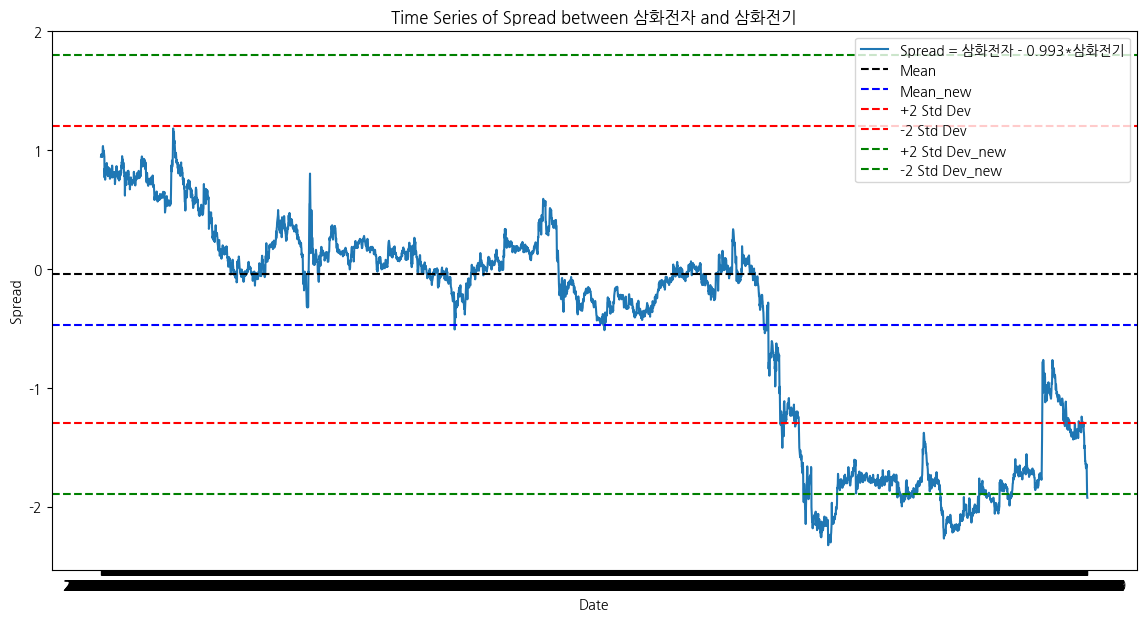

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

mean_spread_total = DBsimul_data_total['Spread'].mean()
std_spread_total = DBsimul_data_total['Spread'].std()

# 시각화
plt.figure(figsize=(14, 7))
plt.plot(DBsimul_data_total['Spread'], label='Spread = 삼화전자 - 0.993*삼화전기')
plt.title('Time Series of Spread between 삼화전자 and 삼화전기')
plt.xlabel('Date')
plt.ylabel('Spread')

# 평균선과 표준편차선 추가
plt.axhline(y=mean_spread, color='k', linestyle='--', label='Mean')
plt.axhline(y=mean_spread_total, color='b', linestyle='--', label='Mean_new')
plt.axhline(y=mean_spread + 2*std_spread, color='r', linestyle='--', label='+2 Std Dev')
plt.axhline(y=mean_spread - 2*std_spread, color='r', linestyle='--', label='-2 Std Dev')
plt.axhline(y=mean_spread + 2*std_spread_total, color='g', linestyle='--', label='+2 Std Dev_new')
plt.axhline(y=mean_spread - 2*std_spread_total, color='g', linestyle='--', label='-2 Std Dev_new')

plt.legend()
plt.show()